In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from time import time

#%matplotlib notebook

## The Lorenz System 

In [2]:
def Lorenz(x, t, p = 28):
    # p = 10,28,40
    x,y,z = x
    dfdt = [10*(y-x), x*(p-z)-y, x*y - (8/3)*z ]
    return dfdt

## Generating Lorenz System data

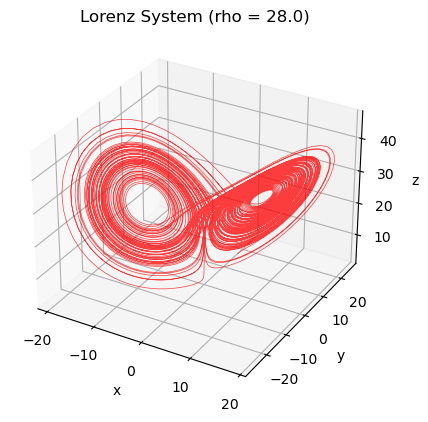

In [3]:
# initial conditions
num_pts = 10001
x0 = [5,5,10]
t = np.linspace(0, 100, num_pts)
dt = 100/num_pts

# system parameters; 
rho_train = [10.,28.,40.]
rho_test = [17.,35.]

sol = odeint(Lorenz, x0, t, args=(rho_train[1],))
x = sol[:,0]; y = sol[:,1]; z = sol[:,2]

# Plotting Lorenz System data
ax = plt.figure().add_subplot(projection='3d')
ax.plot(x,y,z, c='red', lw = 0.5, alpha = 0.75)  # Plot contour curves
ax.set_xlabel('x')  # Plot contour curves
ax.set_ylabel('y')  # Plot contour curves
ax.set_zlabel('z')  # Plot contour curves
ax.set_title('Lorenz System (rho = {})'.format(rho_train[1]))  # Plot contour curves
plt.show()

## Training Data

In [4]:
# Build input data matrix of forward iterates
forward_iters = 5

sol10 = odeint(Lorenz, x0, t, args=(rho_train[0],))
sol28 = odeint(Lorenz, x0, t, args=(rho_train[1],))
sol40 = odeint(Lorenz, x0, t, args=(rho_train[2],))

x10 = sol10[:,0]; y10 = sol10[:,1]; z10 = sol10[:,2]
x28 = sol28[:,0]; y28 = sol28[:,1]; z28 = sol28[:,2]
x40 = sol40[:,0]; y40 = sol40[:,1]; z40 = sol40[:,2]

rho10 = np.repeat(rho_train[0], num_pts-forward_iters)
rho28 = np.repeat(rho_train[1], num_pts-forward_iters)
rho40 = np.repeat(rho_train[2], num_pts-forward_iters)

xn10 = [] ; xn28 = []; xn40 = []

for j in range(forward_iters):
    d10=np.array([x10[j:-forward_iters+j], y10[j:-forward_iters+j], z10[j:-forward_iters+j], rho10],dtype='float32').T
    d28=np.array([x28[j:-forward_iters+j], y28[j:-forward_iters+j], z28[j:-forward_iters+j], rho28],dtype='float32').T
    d40=np.array([x40[j:-forward_iters+j], y40[j:-forward_iters+j], z40[j:-forward_iters+j], rho40],dtype='float32').T

    xn10.append(d10)
    xn28.append(d28)
    xn40.append(d40)

In [5]:
def init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=30, activation = 'relu'):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(input_dim))
    
    layers_seq = num_hidden_layers*[activation]
    layer_neurons = num_hidden_layers*[n_neurons]
    for i in range(num_hidden_layers):
        model.add(layers.Dense(layer_neurons[i],
                               activation=layers_seq[i],
                               kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(output_dim))
    return model

def compute_loss(model, xnforward, steps, loss_name):
    loss = 0
    for s in range(steps):
        if s == 0:
            xpred = model(xnforward[0])
        else:
            xpred = model(xpred)
            
        xnp1 = xnforward[s+1]
        
        if loss_name == 'mse':
            loss += tf.reduce_mean( tf.square( xpred - xnp1 ) )/steps
        elif loss_name == 'mae':
            loss += tf.reduce_mean( tf.abs( xpred - xnp1 ) )/steps
        elif loss_name == 'huber':
            lossfn = tf.keras.losses.Huber(delta=1.0)
            loss += lossfn(xnp1, xpred)
            
    return loss

def get_grad(model, xnforward, steps, loss_name):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, xnforward, steps, loss_name)

    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

In [59]:
def plot_LS_axis(model, rho, M, model_name, mode, x0):
    num_pts = 10001
    
    # TIME SCALE
    if mode == 'normal':
        t = np.linspace(0, 100, num_pts)
        dt = 100/num_pts
    elif mode == 'fine':
        t = np.linspace(0, 50, num_pts)
        dt = 50/num_pts
    elif mode == 'coarse':
        t = np.linspace(0, 250, num_pts)
        dt = 250/num_pts
    else: 
        print('mode error')
    
    # MODEL FORECAST
    sol = odeint(Lorenz, x0, t, args=(rho,))
    x = sol[:,0]; y = sol[:,1]; z = sol[:,2]
    hat = np.zeros((M,4))
    hat[0,0] = x[0]; hat[0,1] = y[0]; hat[0,2] = z[0]
    hat[0,3] = rho
    
    for i in range(1,M):
        #MODEL SW-4
        tp1 = hat[i-1:i,:]
        #keep system parameter same for prediction
        tp1[:,3] = rho
        hat[i] = model(tp1)

    # LYAPUNOV TIME
    rmse = np.sqrt((x[:M]-hat[:M,0])**2+(y[:M]-hat[:M,1])**2+(z[:M]-hat[:M,2])**2)
    try:
        lyind = np.min(np.argwhere(rmse > 2.71828))
        lyaptime = (lyind-1)*dt
    except: 
        lyind = 0
        lyaptime = 0
        

    print('Model {} rho {}: Lyapunov time = {}'.format(model_name,rho,lyaptime))
    
    
    fig, ax = plt.subplots(2,2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    
    fig.suptitle('RNN model prediction vs training data for the Lorenz system (rho = {})'.format(rho), fontsize=16)
    plt.subplots_adjust(hspace=0.75)

    ax[0,0].plot(t[:M], hat[:M,0], c='orange', lw = 0.75)
    ax[0,0].plot(t[:M],x[:M], c='black', lw = 0.75)
    ax[0,0].set_xlabel('time')
    ax[0,0].set_ylabel('x')
    ax[0,0].set_title('x-axis'.format(rho))
    ax[0,0].vlines(lyaptime, ymin =np.min(x),ymax=np.max(x), color = 'red') 
    ax[0,0].legend( ['predicted','true'])

    ax[0,1].plot(t[:M],hat[:M,1], c='orange', lw = 0.75)
    ax[0,1].plot(t[:M],y[:M], c='black', lw = 0.75)
    ax[0,1].vlines(lyaptime, ymin = np.min(y),ymax=np.max(y), color = 'red') 
    ax[0,1].set_xlabel('time')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title('y-axis')
    ax[0,1].legend( ['predicted','true'])

    ax[1,0].plot(t[:M],hat[:M,2], c='orange', lw = 0.75)
    ax[1,0].plot(t[:M],z[:M], c='black', lw = 0.75)
    ax[1,0].vlines(lyaptime, ymin = np.min(z),ymax=np.max(z), color = 'red') 
    ax[1,0].set_xlabel('time')
    ax[1,0].set_ylabel('z')
    ax[1,0].set_title('z-axis')
    ax[1,0].legend( ['predicted','true'])
    
    ax[1,1].plot(t[:(2*lyind+50)],rmse[:(2*lyind+50)], c='orange', lw = 0.75)
    ax[1,1].vlines(lyaptime, ymin = np.min(rmse[:(2*lyind+50)]),ymax=np.max(rmse[:(2*lyind+50)]), color = 'red') 
    ax[1,1].set_xlabel('time')
    ax[1,1].set_ylabel('distance (rmse)')
    ax[1,1].set_title('Euclidean distance vs Time')
    
    plt.savefig('lorenz-{}-{}'.format(model_name, rho), bbox_inches='tight',dpi = 200)

    
    # 3D Plot of Lorenz System
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x,y,z, lw=0.5, alpha=0.75, c='black')
    ax.plot(hat[:,0],hat[:,1],hat[:,2], lw=0.5, alpha=1, c='orange')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Lorenz System (rho = {})'.format(rho))  # Plot contour curves
    plt.savefig('3d-lorenz-{}-{}'.format(model_name, rho), bbox_inches='tight', dpi = 200)

## Experiment 1: Determining the best loss function

In [7]:
hist = {}
n_epoch = 30000

In [ ]:
# 1) HUBER LOSS
@tf.function
def train_step(model, xnforward, steps, loss_name):
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

steps = 3
model_sw3_huber = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=40, activation = 'selu')
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,12000],[1e-2,1e-3,1e-4,1e-5])
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,8000,15000],[1e-2,1e-3,1e-4,1e-5,1e-6])

optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 Huber Training')
t0 = time()  #timer
hist_sw3_huber = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_huber, xn28, steps, 'huber')
    hist_sw3_huber.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

hist['sw3-huber']= hist_sw3_huber
print('\nModel SW-3 Huber Computation time: {} seconds'.format(time()-t0))



In [8]:
# 1) HUBER LOSS
@tf.function
def train_step(model, xnforward, steps, loss_name):
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

steps = 3
model_sw3_huber = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=40, activation = 'selu')
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,12000],[1e-2,1e-3,1e-4,1e-5])
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,8000,15000],[1e-2,1e-3,1e-4,1e-5,1e-6])

optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 Huber Training')
t0 = time()  #timer
hist_sw3_huber = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_huber, xn28, steps, 'huber')
    hist_sw3_huber.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

hist['sw3-huber']= hist_sw3_huber
print('\nModel SW-3 Huber Computation time: {} seconds'.format(time()-t0))


Model SW-3 Huber Training
It 00000: loss = 4.89434967e+01
It 01000: loss = 2.46555150e-01
It 02000: loss = 1.15538044e-02
It 03000: loss = 8.72435234e-03
It 04000: loss = 8.42031278e-03
It 05000: loss = 7.98370037e-03
It 06000: loss = 7.38710444e-03
It 07000: loss = 6.61017094e-03
It 08000: loss = 5.72673883e-03
It 09000: loss = 5.61247766e-03
It 10000: loss = 5.44131454e-03
It 11000: loss = 5.19760605e-03
It 12000: loss = 4.87081520e-03
It 13000: loss = 4.45992639e-03
It 14000: loss = 3.98734305e-03
It 15000: loss = 3.54010053e-03
It 16000: loss = 3.49147618e-03
It 17000: loss = 3.42801586e-03
It 18000: loss = 3.34785040e-03
It 19000: loss = 3.25022452e-03
It 20000: loss = 3.14029120e-03
It 21000: loss = 3.03046172e-03
It 22000: loss = 2.93161115e-03
It 23000: loss = 2.83967191e-03
It 24000: loss = 2.75337719e-03
It 25000: loss = 2.67171627e-03
It 26000: loss = 2.59434502e-03
It 27000: loss = 2.52024480e-03
It 28000: loss = 2.44988175e-03
It 29000: loss = 2.38359859e-03
It 30000: los

Model SW-3-huber-1 rho 28: Lyapunov time = 1.4498550144985503
Model SW-3-huber-2 rho 28: Lyapunov time = 0.06999300069993002


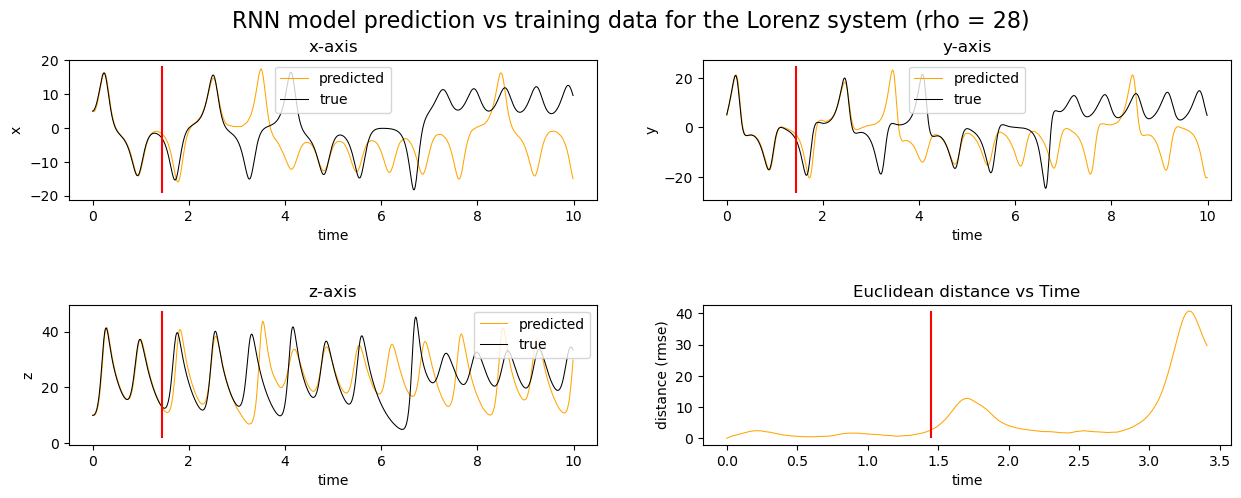

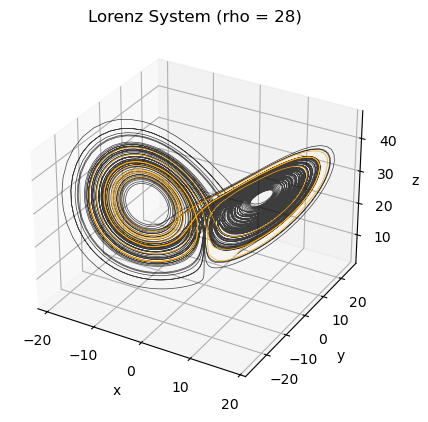

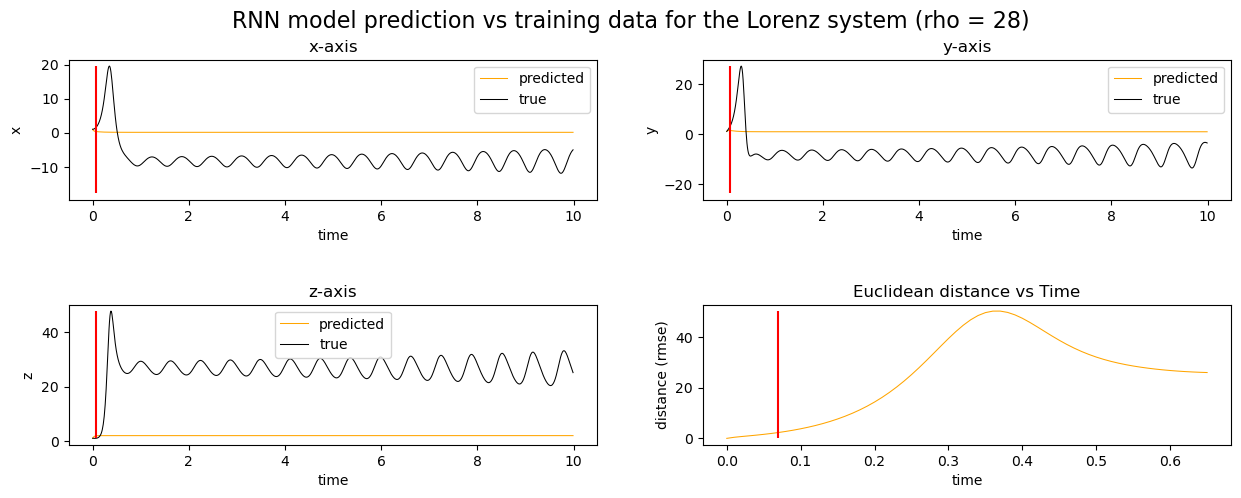

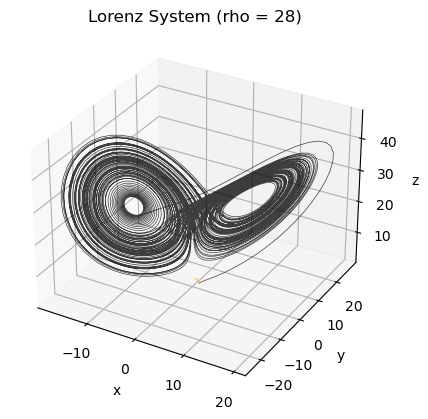

In [60]:
plot_LS_axis(model_sw3_huber, rho = 28, M = 1000, model_name='SW-3-huber-1', mode = 'normal', x0 = [5,5,10])
plot_LS_axis(model_sw3_huber, rho = 28, M = 1000, model_name='SW-3-huber-2', mode = 'normal', x0 = [1,1,1])

In [10]:
# 2) MSE LOSS
@tf.function
def train_step(model, xnforward, steps,loss_name):
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

model_sw3_mse = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=30, activation = 'selu')
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 MSE Training')
t0 = time()  #timer
steps = 3
hist_sw3_mse = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_mse, xn28, steps, 'mse')
    hist_sw3_mse.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

hist['sw3-mse']= hist_sw3_mse
print('\nModel SW-3 MSE Computation time: {} seconds'.format(time()-t0))


Model SW-3 MSE Training
It 00000: loss = 3.88023376e+02
It 01000: loss = 2.29472741e-02
It 02000: loss = 1.45516628e-02
It 03000: loss = 1.06751081e-02
It 04000: loss = 1.02629103e-02
It 05000: loss = 9.69608407e-03
It 06000: loss = 8.96392576e-03
It 07000: loss = 8.05334374e-03
It 08000: loss = 7.07492605e-03
It 09000: loss = 6.09642174e-03
It 10000: loss = 5.18313050e-03
It 11000: loss = 4.46571410e-03
It 12000: loss = 3.93583672e-03
It 13000: loss = 3.52078606e-03
It 14000: loss = 3.19118099e-03
It 15000: loss = 2.92496849e-03
It 16000: loss = 2.63974746e-03
It 17000: loss = 2.42086686e-03
It 18000: loss = 2.23227916e-03
It 19000: loss = 2.06024339e-03
It 20000: loss = 1.91935361e-03
It 21000: loss = 1.80028833e-03
It 22000: loss = 1.69636193e-03
It 23000: loss = 1.79287500e-03
It 24000: loss = 1.51575042e-03
It 25000: loss = 1.43887696e-03
It 26000: loss = 1.54330092e-03
It 27000: loss = 1.30747189e-03
It 28000: loss = 1.24341738e-03
It 29000: loss = 1.19135238e-03
It 30000: loss 

Model SW-3-mse rho 28: Lyapunov time = 0.7799220077992202


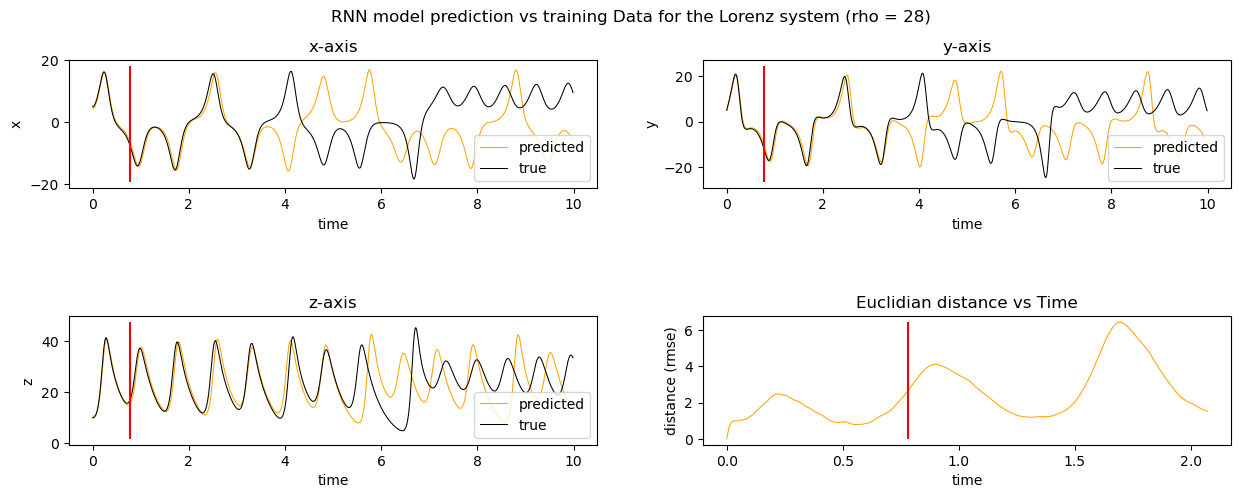

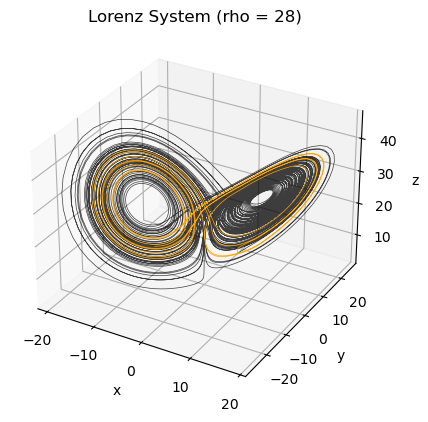

In [11]:
plot_LS_axis(model_sw3_mse, rho = 28, M = 1000, model_name='SW-3-mse', mode = 'normal', x0=[5,5,10])

In [12]:
# 3) MAE LOSS
@tf.function
def train_step(model, xnforward, steps, loss_name):
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

model_sw3_mae = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=30, activation = 'selu')
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 MAE Training')
t0 = time()  #timer
steps = 3
hist_sw3_mae = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_mae, xn28, steps, 'mae')
    hist_sw3_mae.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

hist['sw3-mae']= hist_sw3_mae
print('\nModel SW-3 MAE Computation time: {} seconds'.format(time()-t0))


Model SW-3 MAE Training
It 00000: loss = 1.61433887e+01
It 01000: loss = 2.54330933e-01
It 02000: loss = 8.06093737e-02
It 03000: loss = 6.50070161e-02
It 04000: loss = 5.68066388e-02
It 05000: loss = 5.48377708e-02
It 06000: loss = 5.21642044e-02
It 07000: loss = 4.88541760e-02
It 08000: loss = 4.60194163e-02
It 09000: loss = 4.37860526e-02
It 10000: loss = 4.15686257e-02
It 11000: loss = 3.99225503e-02
It 12000: loss = 3.80925164e-02
It 13000: loss = 3.68016027e-02
It 14000: loss = 3.55926752e-02
It 15000: loss = 3.47158723e-02
It 16000: loss = 3.34265009e-02
It 17000: loss = 3.27927247e-02
It 18000: loss = 3.18239741e-02
It 19000: loss = 3.11527811e-02
It 20000: loss = 3.03053409e-02
It 21000: loss = 2.97639035e-02
It 22000: loss = 2.91419942e-02
It 23000: loss = 2.85843983e-02
It 24000: loss = 2.80824248e-02
It 25000: loss = 2.75981501e-02
It 26000: loss = 2.75135376e-02
It 27000: loss = 2.68634297e-02
It 28000: loss = 2.65606679e-02
It 29000: loss = 2.62265056e-02
It 30000: loss 

Model SW-3-mae rho 28: Lyapunov time = 0.8299170082991701


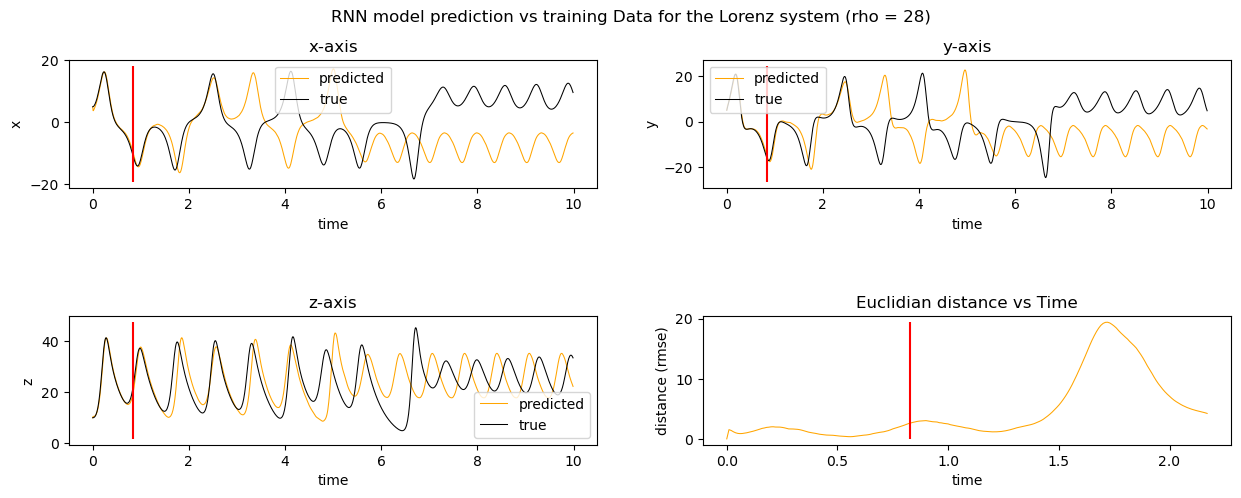

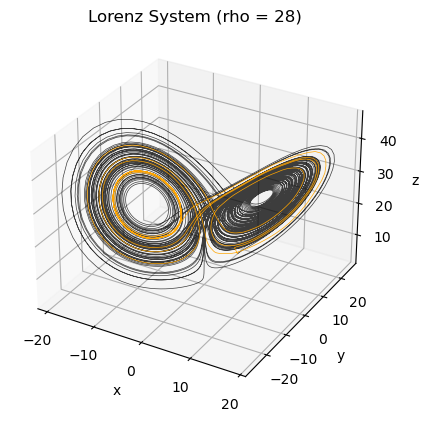

In [13]:
plot_LS_axis(model_sw3_mae, rho = 28, M = 1000, model_name='SW-3-mae', mode = 'normal',x0=[5,5,10])

## Experiment 2: Train Model SW-3 MSE on 3 system parameters

In [14]:
n_epoch = 20000
# Initialize models
@tf.function
def train_step(model, xnforward, steps,loss_name):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

model_sw3_var = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=30, activation = 'selu')
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 Training')
t0 = time()  #timer

steps = 3
hist_sw3_var = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_var, xn10, steps, 'huber')
    loss = loss + train_step(model_sw3_var, xn28, steps, 'huber')
    loss = loss + train_step(model_sw3_var, xn40, steps, 'huber')
    hist_sw3_var.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

hist['sw3-mse-var']= hist_sw3_var
print('\nModel SW-3 Computation time: {} seconds'.format(time()-t0))


Model SW-3 Training
It 00000: loss = 8.43286133e+01
It 01000: loss = 3.00732404e-01
It 02000: loss = 1.66937977e-01
It 03000: loss = 9.41332430e-02
It 04000: loss = 6.11925125e-02
It 05000: loss = 4.62077484e-02
It 06000: loss = 3.62948216e-02
It 07000: loss = 3.04763969e-02
It 08000: loss = 2.78879944e-02
It 09000: loss = 2.43426729e-02
It 10000: loss = 2.12591402e-02
It 11000: loss = 1.94775537e-02
It 12000: loss = 2.02516932e-02
It 13000: loss = 1.87860727e-02
It 14000: loss = 2.79824138e-02
It 15000: loss = 1.50645524e-02
It 16000: loss = 1.43465539e-02
It 17000: loss = 2.12976299e-02
It 18000: loss = 1.34036876e-02
It 19000: loss = 1.38296513e-02
It 20000: loss = 1.25024859e-02

Model SW-3 Computation time: 770.6319715976715 seconds


## Forecast Model SW-3 with variable system parameters

Model SW-3-var rho 10: Lyapunov time = 0
Model SW-3-var rho 17: Lyapunov time = 0.029997000299970003
Model SW-3-var rho 28: Lyapunov time = 1.4198580141985802
Model SW-3-var rho 35: Lyapunov time = 0.6899310068993101
Model SW-3-var rho 40: Lyapunov time = 0.10998900109989002


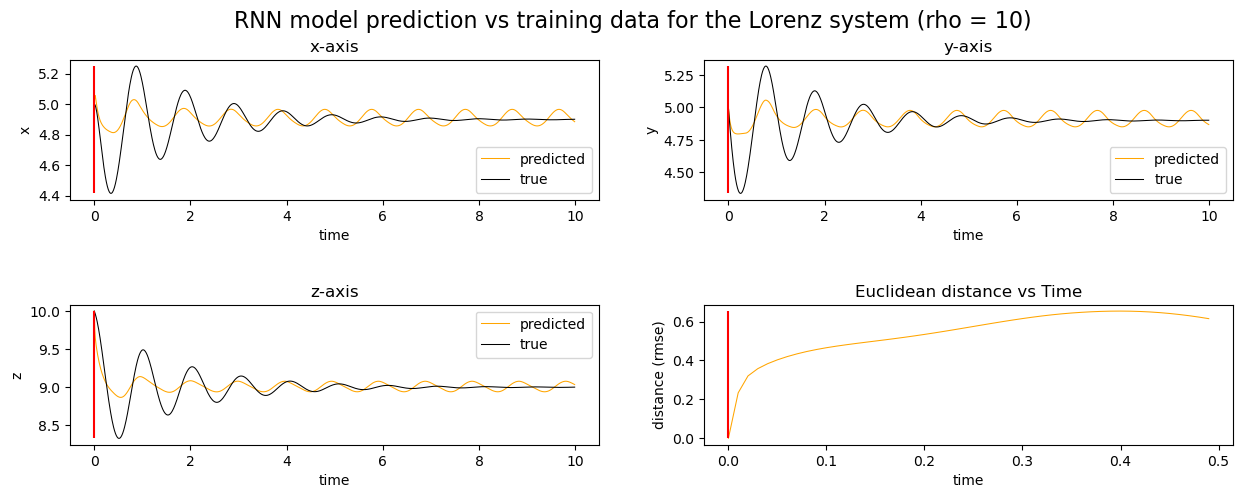

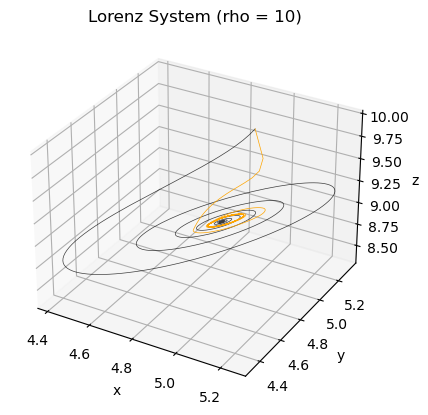

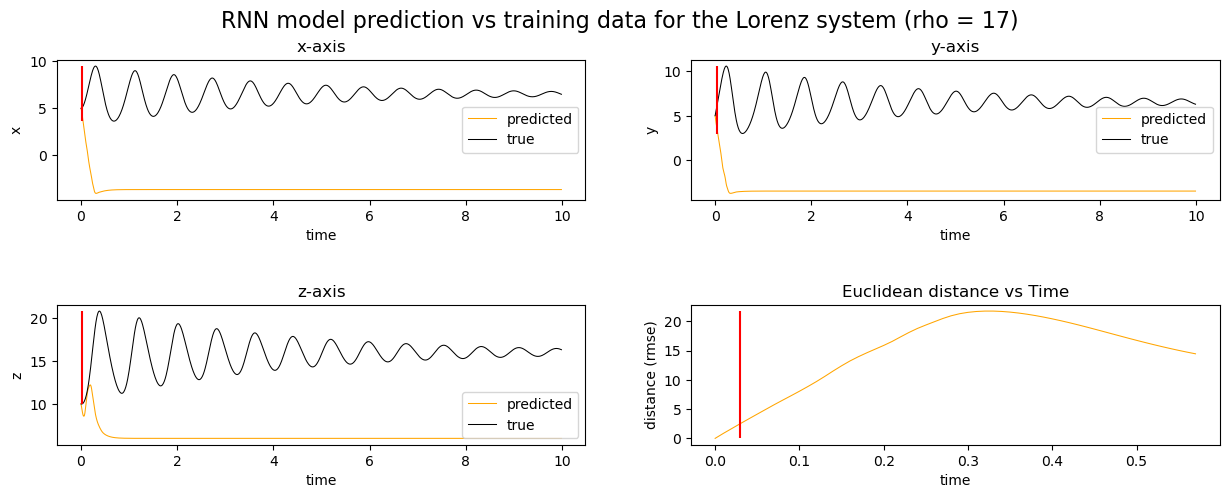

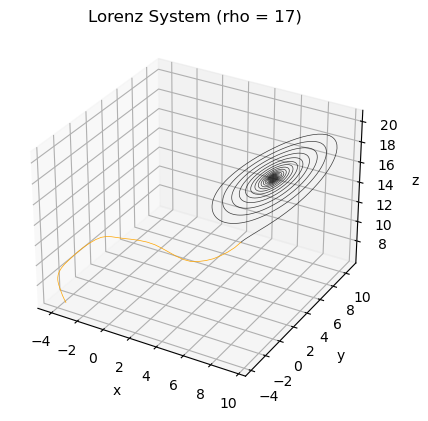

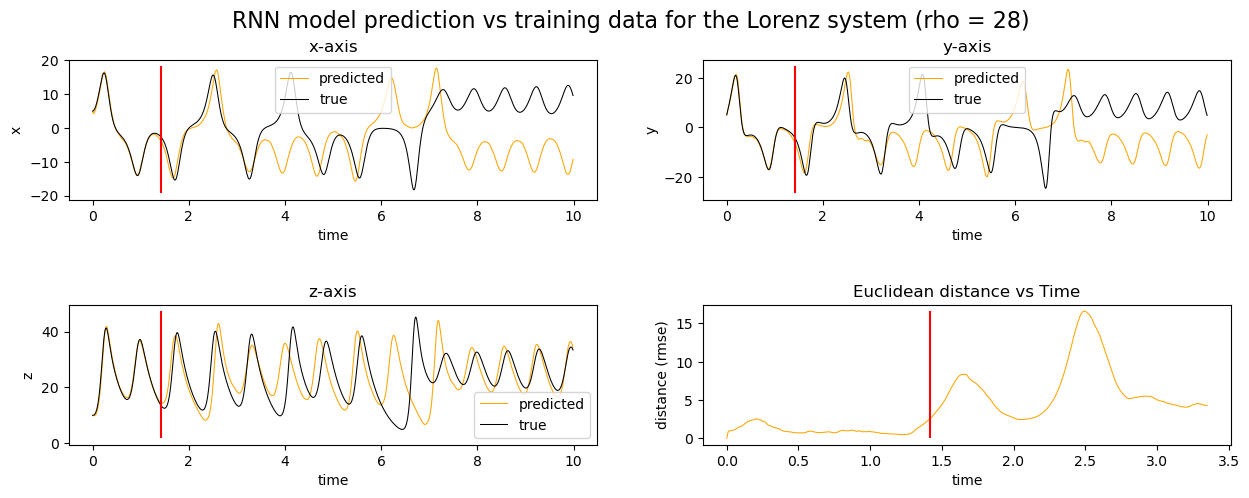

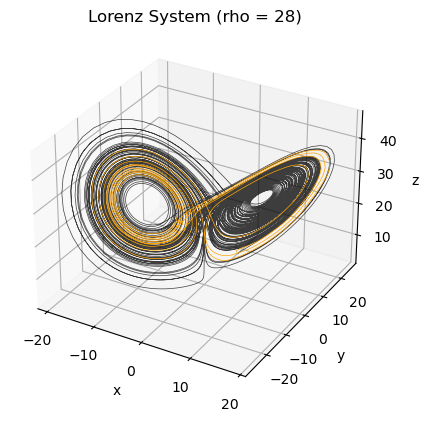

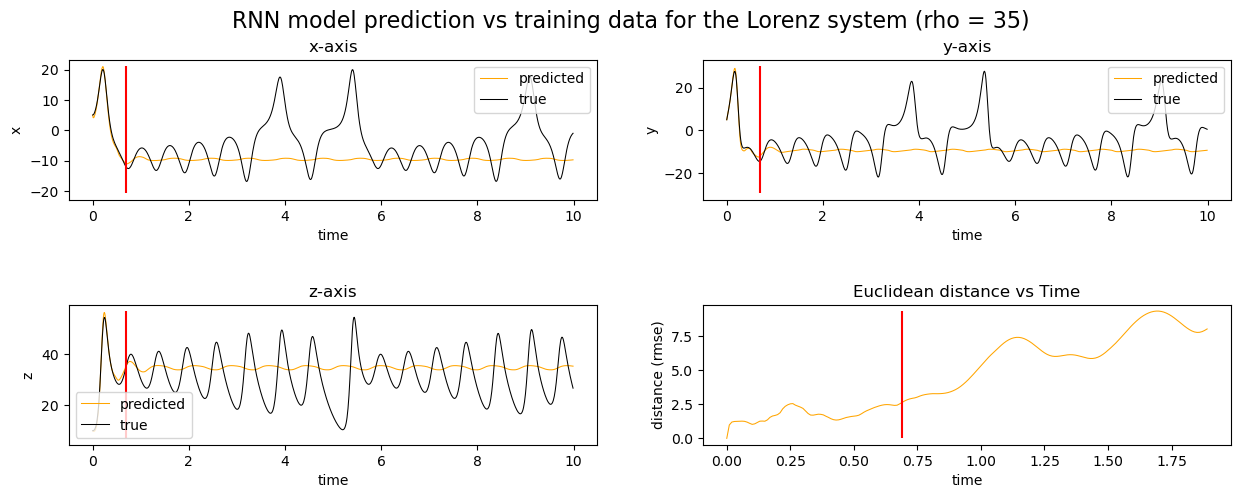

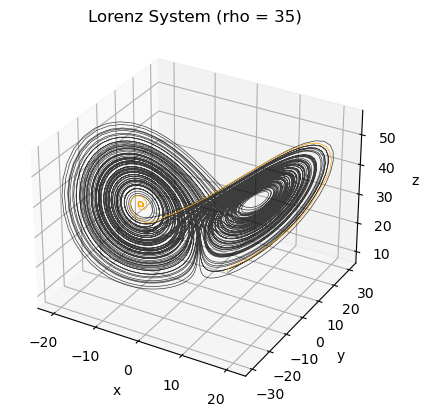

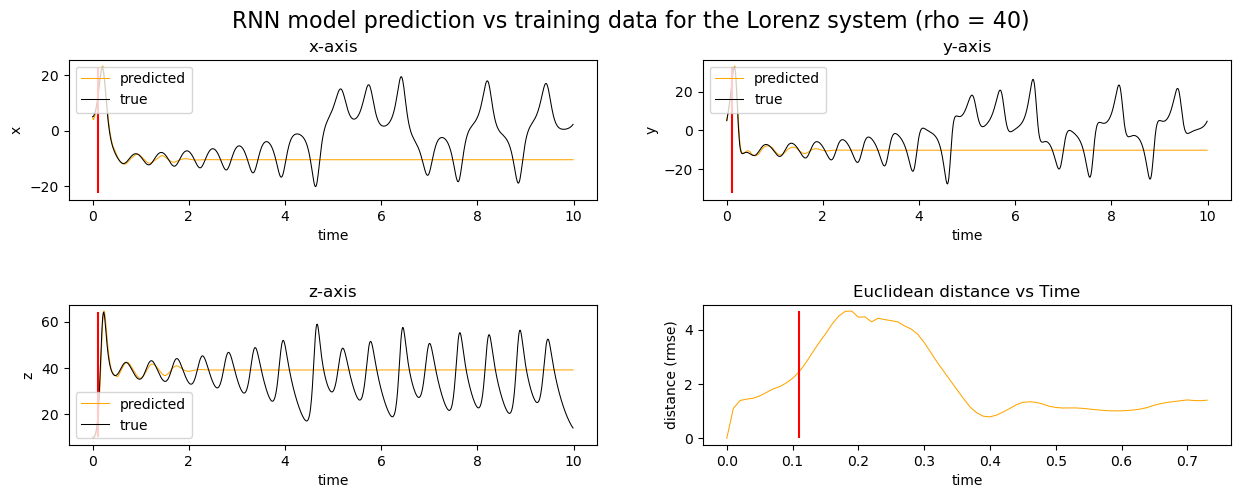

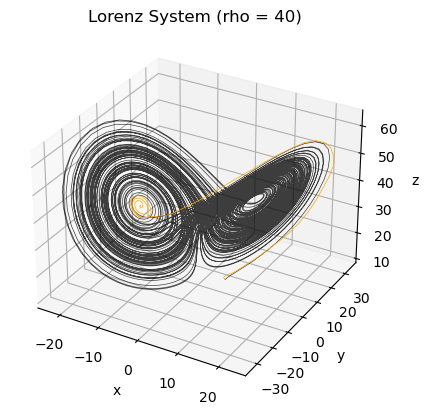

In [61]:
rho_list = [10,17,28,35,40]
for rho in rho_list:
    plot_LS_axis(model_sw3_var, rho = rho, M = 1000, model_name='SW-3-var', mode = 'normal',x0=[5,5,10])

## Experiment 3: Train Model SW-3 MSE on variable time-scale 

In [16]:
# initial conditions
num_pts = 10001
x0 = [8,8,27]
tfine = np.linspace(0, 50, num_pts)
tcoarse = np.linspace(0, 250, num_pts)

# system parameters;
rho_train = [10.,28.,40.]
rho_test = [17.,35.]

# Build input data matrix of forward iterates
forward_iters = 5

#FINE GRAIN TIME
sol10f = odeint(Lorenz, x0, tfine, args=(rho_train[0],))
sol28f = odeint(Lorenz, x0, tfine, args=(rho_train[1],))
sol40f = odeint(Lorenz, x0, tfine, args=(rho_train[2],))

x10f = sol10f[:,0]; y10f = sol10f[:,1]; z10f = sol10f[:,2]
x28f = sol28f[:,0]; y28f = sol28f[:,1]; z28f = sol28f[:,2]
x40f = sol40f[:,0]; y40f = sol40f[:,1]; z40f = sol40f[:,2]

xn10f = [] ; xn28f = []; xn40f = []

#COARSE GRAIN TIME
sol10c = odeint(Lorenz, x0, tcoarse, args=(rho_train[0],))
sol28c = odeint(Lorenz, x0, tcoarse, args=(rho_train[1],))
sol40c = odeint(Lorenz, x0, tcoarse, args=(rho_train[2],))

x10c = sol10c[:,0]; y10c = sol10c[:,1]; z10c = sol10c[:,2]
x28c = sol28c[:,0]; y28c = sol28c[:,1]; z28c = sol28c[:,2]
x40c = sol40c[:,0]; y40c = sol40c[:,1]; z40c = sol40c[:,2]

rho10 = np.repeat(rho_train[0], num_pts-forward_iters)
rho28 = np.repeat(rho_train[1], num_pts-forward_iters)
rho40 = np.repeat(rho_train[2], num_pts-forward_iters)

xn10c = [] ; xn28c = []; xn40c = []

for j in range(forward_iters):
    d10f=np.array([x10f[j:-forward_iters+j], y10f[j:-forward_iters+j], z10f[j:-forward_iters+j], rho10],dtype='float32').T
    d28f=np.array([x28f[j:-forward_iters+j], y28f[j:-forward_iters+j], z28f[j:-forward_iters+j], rho28],dtype='float32').T
    d40f=np.array([x40f[j:-forward_iters+j], y40f[j:-forward_iters+j], z40f[j:-forward_iters+j], rho40],dtype='float32').T
    
    d10c=np.array([x10c[j:-forward_iters+j], y10c[j:-forward_iters+j], z10c[j:-forward_iters+j], rho10],dtype='float32').T
    d28c=np.array([x28c[j:-forward_iters+j], y28c[j:-forward_iters+j], z28c[j:-forward_iters+j], rho28],dtype='float32').T
    d40c=np.array([x40c[j:-forward_iters+j], y40c[j:-forward_iters+j], z40c[j:-forward_iters+j], rho40],dtype='float32').T
    
    xn10f.append(d10f)
    xn28f.append(d28f)
    xn40f.append(d40f)
    
    xn10c.append(d10c)
    xn28c.append(d28c)
    xn40c.append(d40c)


## Fine Grain Training

In [17]:
n_epoch = 20000

# Initialize models
@tf.function
def train_step(model, xnforward, steps, loss_name):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

model_sw3_fine = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=30, activation = 'selu')
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 Fine Training')
t0 = time()  #timer

steps = 3
hist_sw3_fine = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_fine, xn10f, steps, 'huber')
    loss = loss + train_step(model_sw3_fine, xn28f, steps, 'huber')
    loss = loss + train_step(model_sw3_fine, xn40f, steps, 'huber')
    hist_sw3_fine.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
hist['sw3-mse-fine']= hist_sw3_fine
print('\nModel SW-3 Fine Computation time: {} seconds'.format(time()-t0))


Model SW-3 Fine Training
It 00000: loss = 1.30798050e+02
It 01000: loss = 3.09079170e-01
It 02000: loss = 1.50947079e-01
It 03000: loss = 8.04772973e-02
It 04000: loss = 5.62207326e-02
It 05000: loss = 5.40523604e-02
It 06000: loss = 3.78547050e-02
It 07000: loss = 3.28332484e-02
It 08000: loss = 4.09579426e-02
It 09000: loss = 2.63270102e-02
It 10000: loss = 2.42489688e-02
It 11000: loss = 2.24402323e-02
It 12000: loss = 2.15837453e-02
It 13000: loss = 1.96983572e-02
It 14000: loss = 1.90849826e-02
It 15000: loss = 1.77150406e-02
It 16000: loss = 1.68740526e-02
It 17000: loss = 1.62265077e-02
It 18000: loss = 1.60388388e-02
It 19000: loss = 1.50514664e-02
It 20000: loss = 1.45889353e-02

Model SW-3 Fine Computation time: 820.5657150745392 seconds


## Fine Grain Forecast

Model SW-3-fine rho 10: Lyapunov time = 0.8299170082991701
Model SW-3-fine rho 17: Lyapunov time = 0.004999500049995001
Model SW-3-fine rho 28: Lyapunov time = 1.5848415158484153
Model SW-3-fine rho 35: Lyapunov time = 0.624937506249375
Model SW-3-fine rho 40: Lyapunov time = 1.2098790120987901


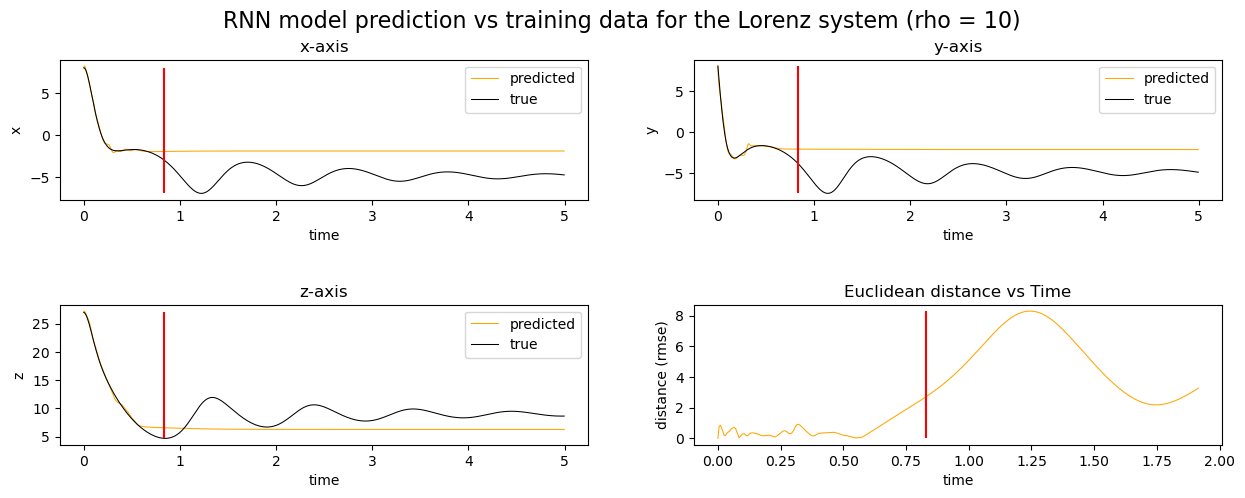

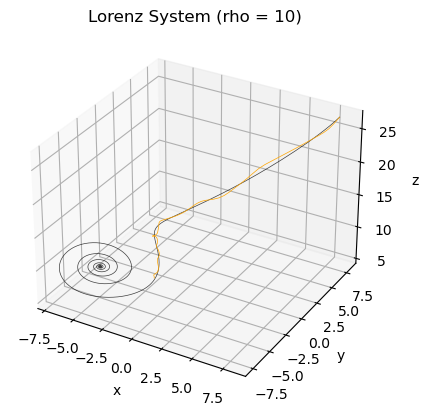

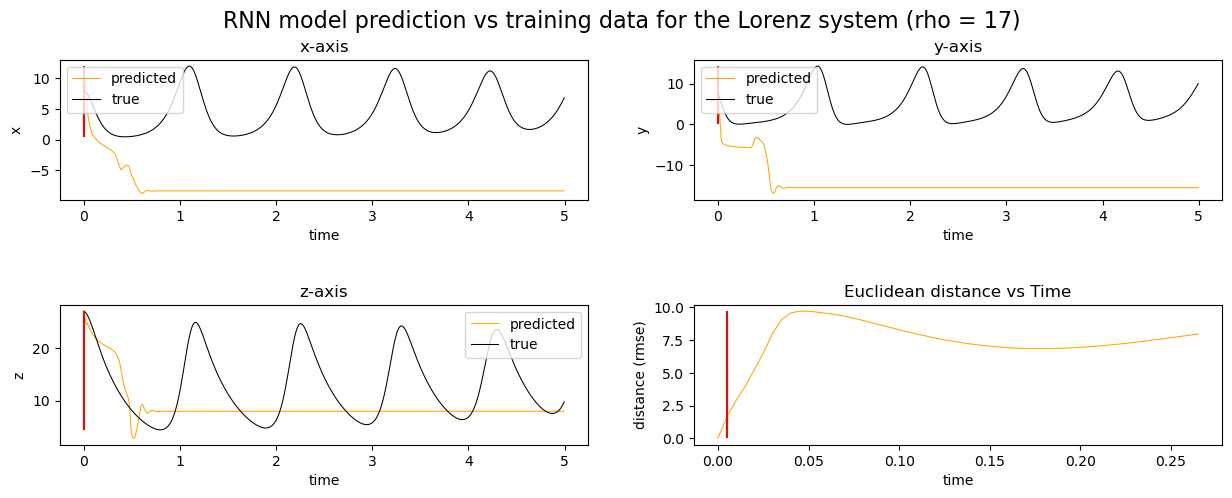

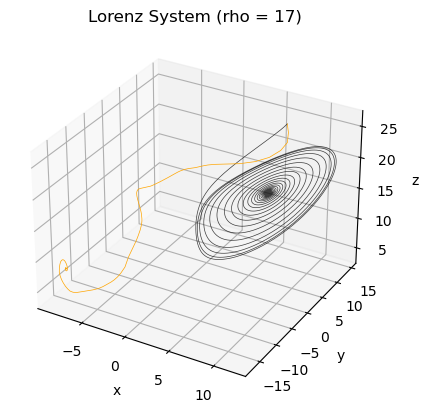

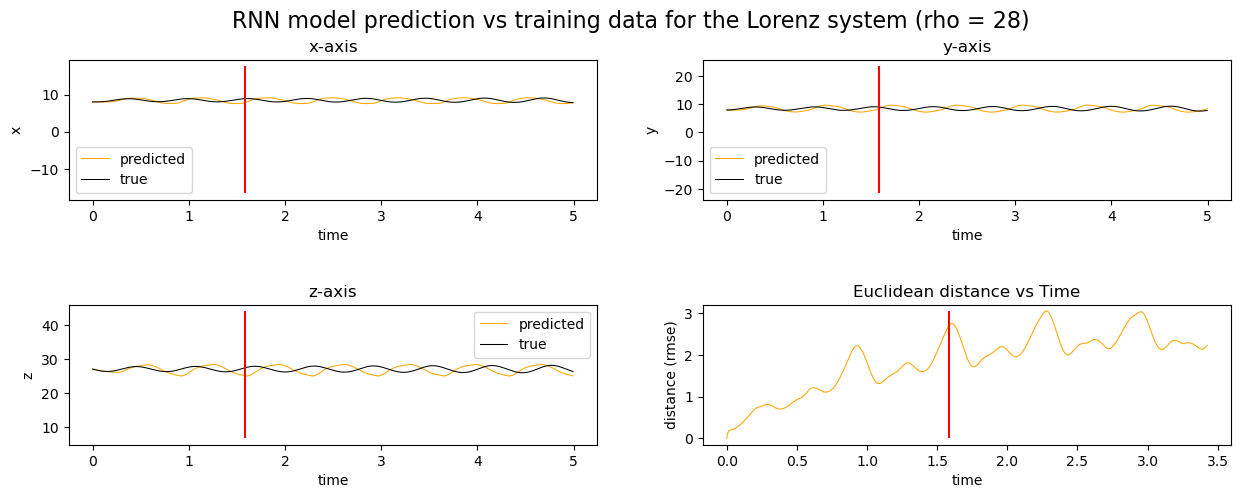

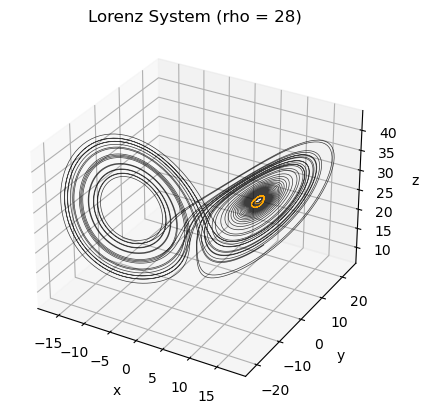

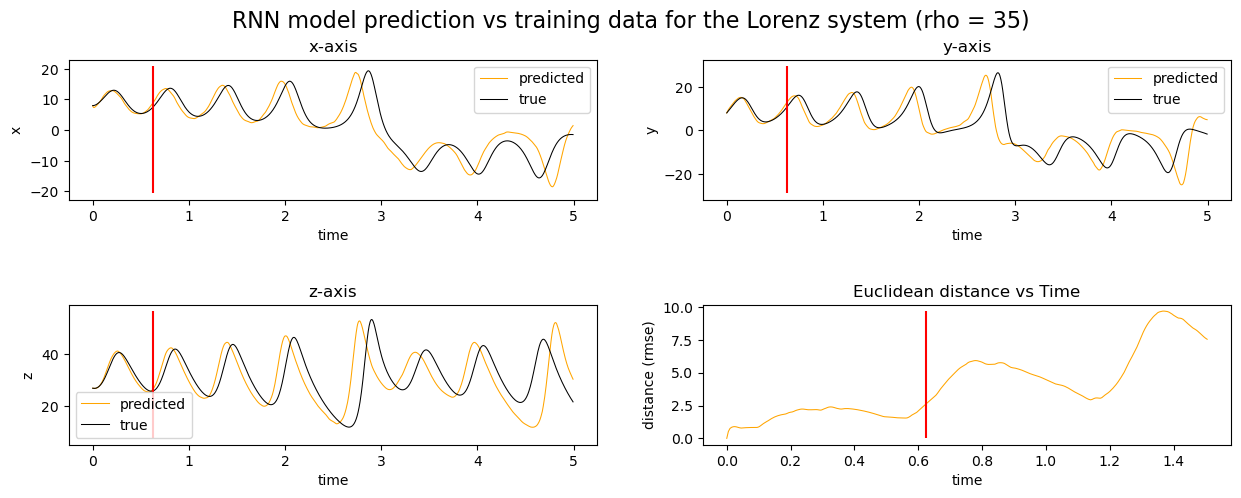

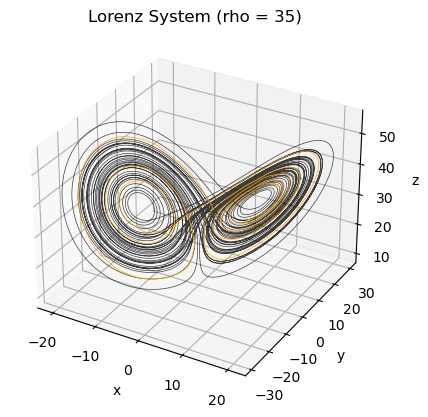

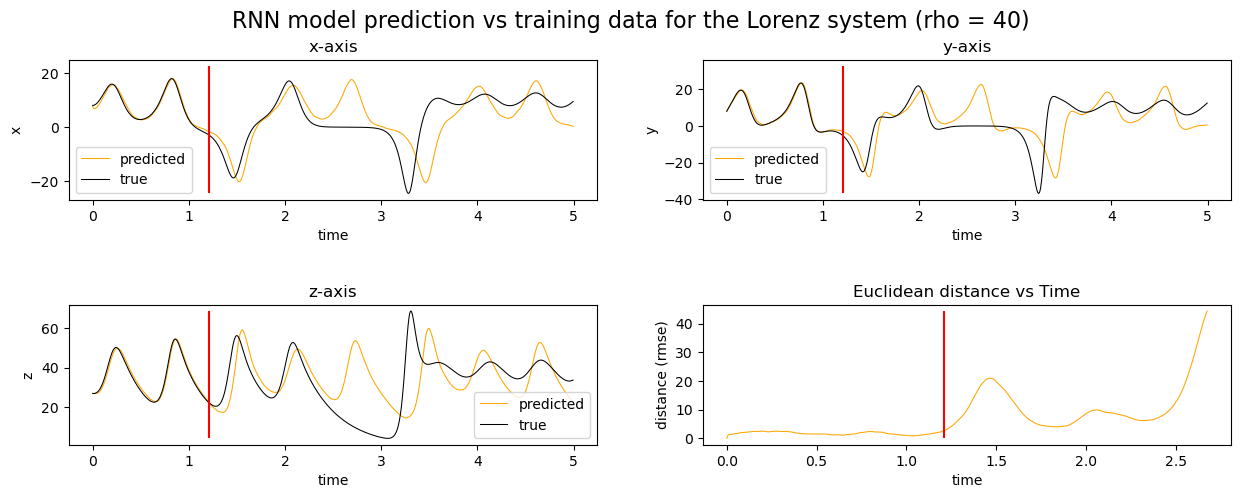

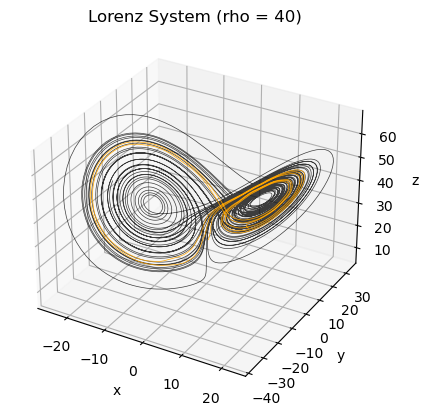

In [62]:
rho_list = [10,17,28,35,40]
for rho in rho_list:
    plot_LS_axis(model_sw3_fine, rho = rho, M = 1000, model_name='SW-3-fine', mode ='fine', x0 = [8,8,27])

## Coarse Grain Training

In [19]:
n_epoch = 20000

# Initialize models
@tf.function
def train_step(model, xnforward, steps, loss_name):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, xnforward, steps, loss_name)
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

model_sw3_coarse = init_model(num_hidden_layers = 4, input_dim = 4, output_dim = 4, n_neurons=30, activation = 'selu')
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

print('\nModel SW-3 Coarse Training')
t0 = time()  #timer

steps = 3
hist_sw3_coarse = []
for i in range(n_epoch+1):
    loss = train_step(model_sw3_coarse, xn10c, steps, 'huber')
    loss = loss + train_step(model_sw3_coarse, xn28c, steps, 'huber')
    loss = loss + train_step(model_sw3_coarse, xn40c, steps, 'huber')
    hist_sw3_coarse.append(loss.numpy())
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

hist['sw3-mse-coarse']=hist_sw3_coarse
print('\nModel SW-3 Coarse Computation time: {} seconds'.format(time()-t0))


Model SW-3 Coarse Training
It 00000: loss = 1.38410400e+02
It 01000: loss = 3.76916230e-01
It 02000: loss = 2.16681063e-01
It 03000: loss = 1.20201707e-01
It 04000: loss = 8.01083446e-02
It 05000: loss = 6.01274967e-02
It 06000: loss = 4.55051437e-02
It 07000: loss = 3.67298871e-02
It 08000: loss = 3.21297385e-02
It 09000: loss = 2.90031116e-02
It 10000: loss = 2.60424577e-02
It 11000: loss = 2.48642471e-02
It 12000: loss = 2.29900219e-02
It 13000: loss = 2.11702734e-02
It 14000: loss = 2.15682574e-02
It 15000: loss = 1.96870472e-02
It 16000: loss = 1.84092354e-02
It 17000: loss = 1.79386139e-02
It 18000: loss = 2.05996260e-02
It 19000: loss = 1.64160598e-02
It 20000: loss = 1.62358731e-02

Model SW-3 Coarse Computation time: 779.7996230125427 seconds


## Coarse Grain Forecast

Model SW-3-coarse rho 10: Lyapunov time = 0.724927507249275
Model SW-3-coarse rho 17: Lyapunov time = 0.14998500149985
Model SW-3-coarse rho 28: Lyapunov time = 3.9246075392460753
Model SW-3-coarse rho 35: Lyapunov time = 1.2998700129987
Model SW-3-coarse rho 40: Lyapunov time = 2.624737526247375


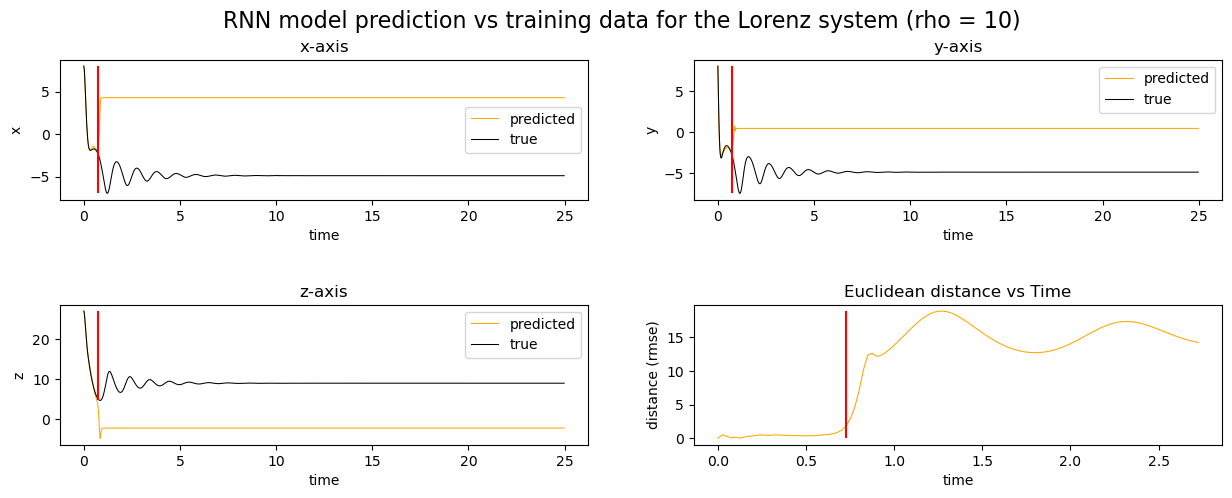

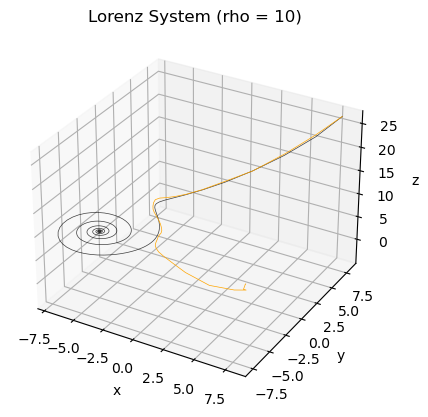

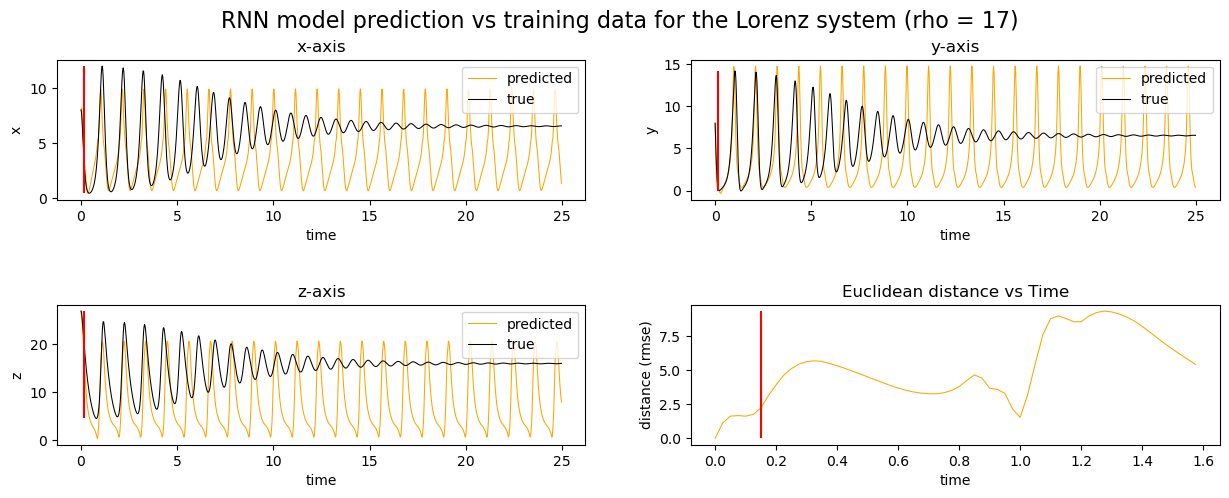

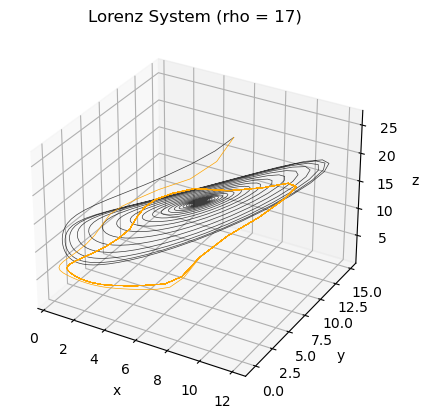

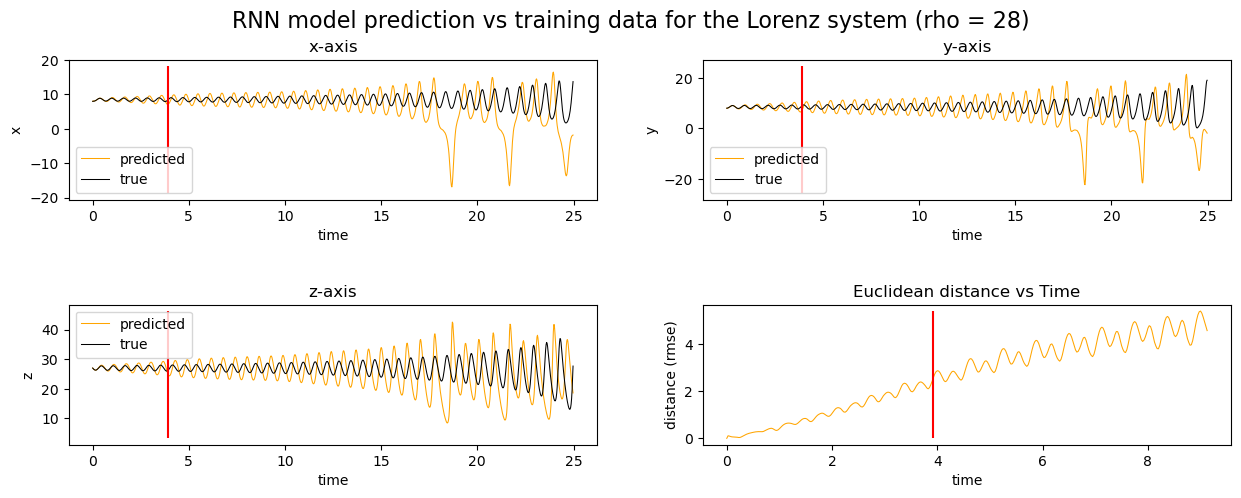

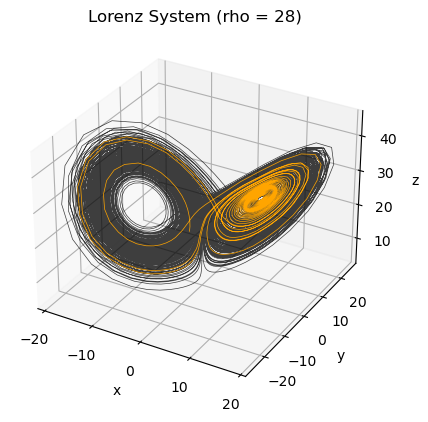

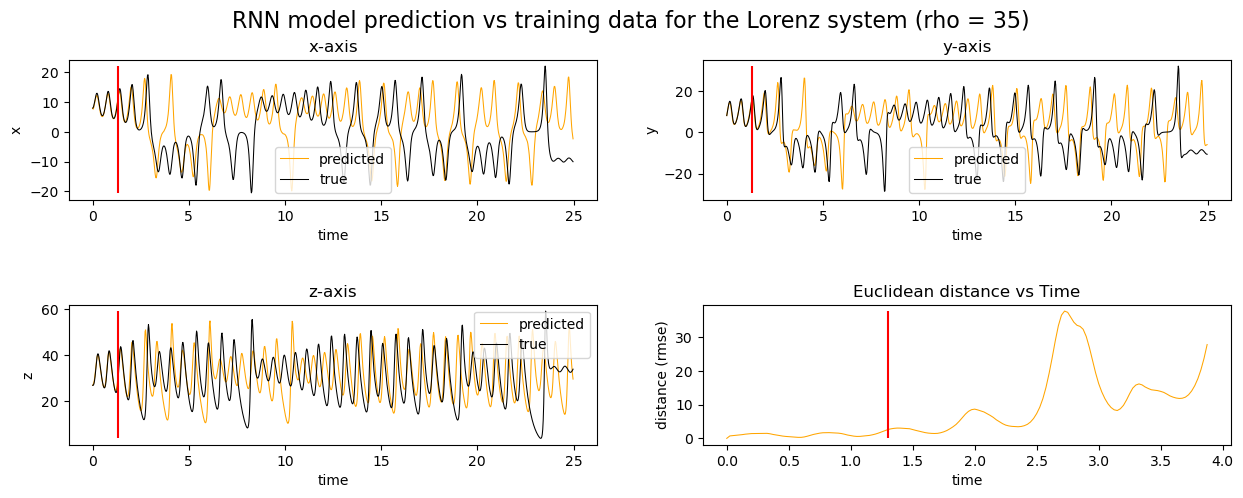

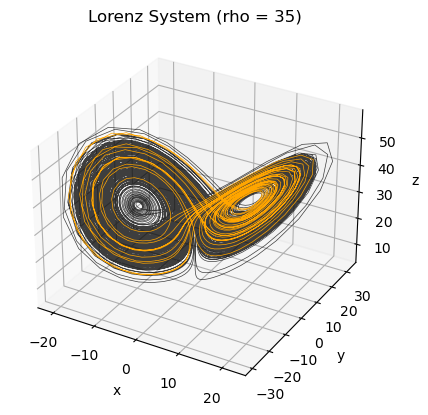

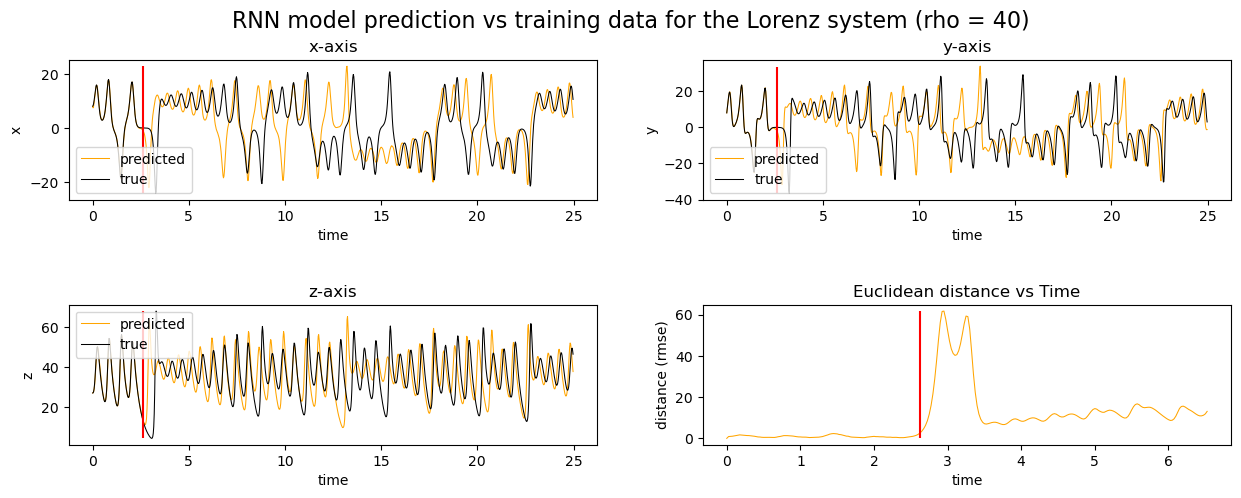

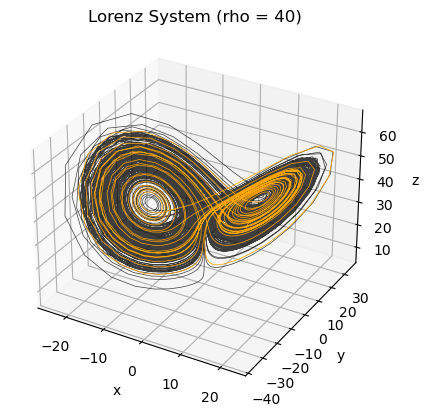

In [63]:
rho_list = [10,17,28,35,40]
for rho in rho_list:
    plot_LS_axis(model_sw3_coarse, rho = rho, M = 1000, model_name='SW-3-coarse', mode = 'coarse', x0=[8,8,27])

## Experiment 4: Predicting Lobe Transitions

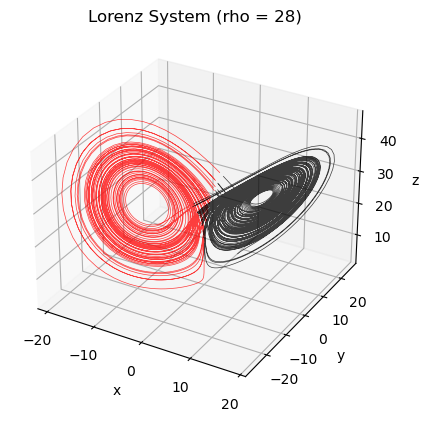

In [21]:
x_pos = np.argwhere(x>0)
x_neg = np.argwhere(x<0)

X0 = x.copy(); Y0 = y.copy(); Z0 = z.copy() 
X0[x_pos]=np.nan; Y0[x_pos]=np.nan ; Z0[x_pos]=np.nan

X1 = x.copy(); Y1 = y.copy(); Z1 = z.copy() 
X1[x_neg]=np.nan; Y1[x_neg]=np.nan ; Z1[x_neg]=np.nan

x1 = x[x_pos].reshape(-1); y1 = y[x_pos].reshape(-1); z1 = z[x_pos].reshape(-1)
x0 = x[x_neg].reshape(-1); y0 = y[x_neg].reshape(-1); z0 = z[x_neg].reshape(-1)

# Plotting Lorenz System
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X0,Y0,Z0, c='red', lw = 0.5, alpha = 0.75)  # Plot contour curves
ax.plot(X1,Y1,Z1, c='black', lw = 0.5, alpha = 0.75)  # Plot contour curves
ax.set_xlabel('x')  # Plot contour curves
ax.set_ylabel('y')  # Plot contour curves
ax.set_zlabel('z')  # Plot contour curves
ax.set_title('Lorenz System (rho = {})'.format(28))  # Plot contour curves
plt.show()

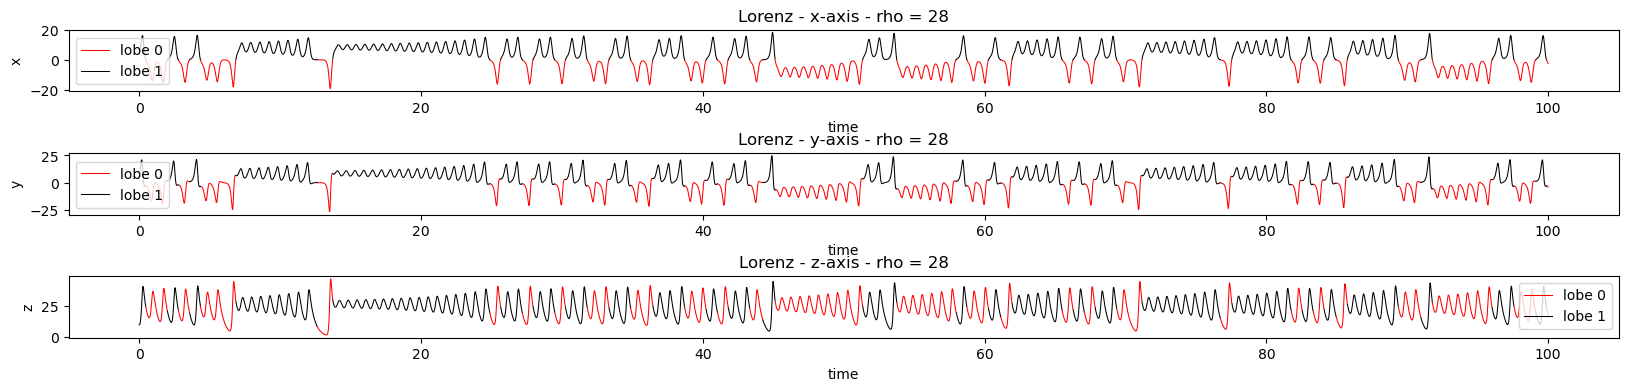

In [22]:
# Plotting Lorenz System Lobes
fig, ax = plt.subplots(3,1)
fig.set_figwidth(20)
fig.set_figheight(4)

ax[0].plot(t,X0, c='red', lw = 0.75)
ax[0].plot(t,X1, c='black', lw = 0.75)
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
ax[0].set_title('Lorenz - x-axis - rho = {}'.format(28))
ax[0].legend( ['lobe 0','lobe 1'])

ax[1].plot(t,Y0, c='red', lw = 0.75)
ax[1].plot(t,Y1, c='black', lw = 0.75)
ax[1].set_xlabel('time')
ax[1].set_ylabel('y')
ax[1].set_title('Lorenz - y-axis - rho = {}'.format(28))
ax[1].legend( ['lobe 0','lobe 1'])

ax[2].plot(t,Z0, c='red', lw = 0.75)
ax[2].plot(t,Z1, c='black', lw = 0.75)
ax[2].set_xlabel('time')
ax[2].set_ylabel('z')
ax[2].set_title('Lorenz - z-axis - rho = {}'.format(28))
ax[2].legend( ['lobe 0','lobe 1'])

plt.subplots_adjust(hspace=1)
plt.savefig('lorenz-lobes-28', bbox_inches='tight',dpi = 200)

## Lobe States and Transitions

Text(0.5, 1.0, 'Lobe vs Time')

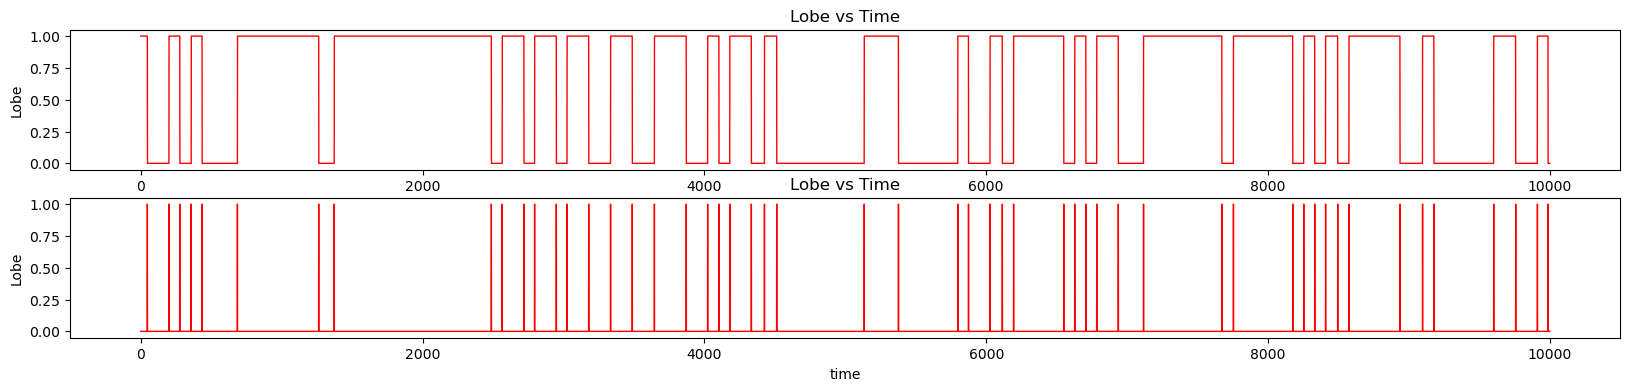

In [24]:
ylobe = np.ones(num_pts)
ylobe[x_neg] = 0

ytrans = np.abs(ylobe[1:num_pts] - ylobe[0:(num_pts-1)])

fig, ax = plt.subplots(2,1)
fig.set_figwidth(20)
fig.set_figheight(4)

ax[0].plot(ylobe, c='red', lw = 1)
ax[0].set_xlabel('time')
ax[0].set_ylabel('Lobe')
ax[0].set_title('Lobe vs Time')

ax[1].plot(ytrans, c='red', lw = 1)
ax[1].set_xlabel('time')
ax[1].set_ylabel('Lobe')
ax[1].set_title('Lobe vs Time')


## Building a basic network to predict lobe transitions

In [25]:
xlobe = np.array([x,y,z]).T
xlobe.shape

(10001, 3)

In [26]:
def classif_model(num_hidden_layers = 4, input_dim = 3, output_dim =1 , n_neurons=30, activation = 'relu'):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(input_dim))
    
    layers_seq = num_hidden_layers*[activation]
    layer_neurons = num_hidden_layers*[n_neurons]
    for i in range(num_hidden_layers):
        model.add(layers.Dense(layer_neurons[i],
                               activation=layers_seq[i],
                               kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics='accuracy')
    
    return model

lobe_state_model = classif_model(num_hidden_layers = 4, input_dim =3, output_dim =1, n_neurons=50, activation = 'relu')
lobe_trans_model = classif_model(num_hidden_layers = 4, input_dim =3, output_dim =1, n_neurons=50, activation = 'relu')

history_lobe = lobe_state_model.fit(xlobe, ylobe, verbose=2, epochs=500)

Epoch 1/500
313/313 - 1s - loss: 0.0629 - accuracy: 0.9771 - 735ms/epoch - 2ms/step
Epoch 2/500
313/313 - 0s - loss: 0.0179 - accuracy: 0.9932 - 213ms/epoch - 682us/step
Epoch 3/500
313/313 - 0s - loss: 0.0157 - accuracy: 0.9935 - 212ms/epoch - 676us/step
Epoch 4/500
313/313 - 0s - loss: 0.0146 - accuracy: 0.9935 - 206ms/epoch - 657us/step
Epoch 5/500
313/313 - 0s - loss: 0.0088 - accuracy: 0.9967 - 201ms/epoch - 642us/step
Epoch 6/500
313/313 - 0s - loss: 0.0102 - accuracy: 0.9957 - 206ms/epoch - 659us/step
Epoch 7/500
313/313 - 0s - loss: 0.0096 - accuracy: 0.9962 - 209ms/epoch - 668us/step
Epoch 8/500
313/313 - 0s - loss: 0.0068 - accuracy: 0.9976 - 208ms/epoch - 665us/step
Epoch 9/500
313/313 - 0s - loss: 0.0067 - accuracy: 0.9976 - 213ms/epoch - 681us/step
Epoch 10/500
313/313 - 0s - loss: 0.0069 - accuracy: 0.9975 - 215ms/epoch - 686us/step
Epoch 11/500
313/313 - 0s - loss: 0.0085 - accuracy: 0.9965 - 213ms/epoch - 681us/step
Epoch 12/500
313/313 - 0s - loss: 0.0074 - accuracy: 0

Epoch 96/500
313/313 - 0s - loss: 0.0020 - accuracy: 0.9991 - 206ms/epoch - 659us/step
Epoch 97/500
313/313 - 0s - loss: 0.0014 - accuracy: 0.9996 - 208ms/epoch - 665us/step
Epoch 98/500
313/313 - 0s - loss: 0.0014 - accuracy: 0.9995 - 212ms/epoch - 677us/step
Epoch 99/500
313/313 - 0s - loss: 0.0011 - accuracy: 0.9995 - 209ms/epoch - 668us/step
Epoch 100/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9994 - 211ms/epoch - 675us/step
Epoch 101/500
313/313 - 0s - loss: 0.0016 - accuracy: 0.9993 - 209ms/epoch - 668us/step
Epoch 102/500
313/313 - 0s - loss: 0.0018 - accuracy: 0.9994 - 208ms/epoch - 666us/step
Epoch 103/500
313/313 - 0s - loss: 0.0016 - accuracy: 0.9993 - 209ms/epoch - 668us/step
Epoch 104/500
313/313 - 0s - loss: 0.0019 - accuracy: 0.9991 - 211ms/epoch - 674us/step
Epoch 105/500
313/313 - 0s - loss: 0.0013 - accuracy: 0.9995 - 209ms/epoch - 668us/step
Epoch 106/500
313/313 - 0s - loss: 9.4519e-04 - accuracy: 0.9996 - 210ms/epoch - 671us/step
Epoch 107/500
313/313 - 0s - los

Epoch 189/500
313/313 - 0s - loss: 0.0020 - accuracy: 0.9996 - 211ms/epoch - 674us/step
Epoch 190/500
313/313 - 0s - loss: 9.9516e-04 - accuracy: 0.9997 - 212ms/epoch - 677us/step
Epoch 191/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9997 - 213ms/epoch - 681us/step
Epoch 192/500
313/313 - 0s - loss: 7.2293e-04 - accuracy: 0.9997 - 215ms/epoch - 687us/step
Epoch 193/500
313/313 - 0s - loss: 0.0014 - accuracy: 0.9996 - 214ms/epoch - 682us/step
Epoch 194/500
313/313 - 0s - loss: 8.8053e-04 - accuracy: 0.9996 - 217ms/epoch - 693us/step
Epoch 195/500
313/313 - 0s - loss: 0.0023 - accuracy: 0.9994 - 211ms/epoch - 675us/step
Epoch 196/500
313/313 - 0s - loss: 7.8444e-04 - accuracy: 0.9998 - 216ms/epoch - 690us/step
Epoch 197/500
313/313 - 0s - loss: 0.0013 - accuracy: 0.9996 - 213ms/epoch - 681us/step
Epoch 198/500
313/313 - 0s - loss: 0.0013 - accuracy: 0.9995 - 215ms/epoch - 687us/step
Epoch 199/500
313/313 - 0s - loss: 0.0017 - accuracy: 0.9997 - 216ms/epoch - 691us/step
Epoch 200/500
31

Epoch 281/500
313/313 - 0s - loss: 0.0011 - accuracy: 0.9996 - 210ms/epoch - 672us/step
Epoch 282/500
313/313 - 0s - loss: 7.4852e-04 - accuracy: 0.9995 - 210ms/epoch - 671us/step
Epoch 283/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9996 - 211ms/epoch - 673us/step
Epoch 284/500
313/313 - 0s - loss: 6.3029e-04 - accuracy: 0.9997 - 208ms/epoch - 665us/step
Epoch 285/500
313/313 - 0s - loss: 7.0916e-04 - accuracy: 0.9996 - 209ms/epoch - 668us/step
Epoch 286/500
313/313 - 0s - loss: 0.0018 - accuracy: 0.9993 - 207ms/epoch - 661us/step
Epoch 287/500
313/313 - 0s - loss: 9.3806e-04 - accuracy: 0.9997 - 207ms/epoch - 661us/step
Epoch 288/500
313/313 - 0s - loss: 0.0017 - accuracy: 0.9996 - 210ms/epoch - 671us/step
Epoch 289/500
313/313 - 0s - loss: 9.3877e-04 - accuracy: 0.9995 - 210ms/epoch - 671us/step
Epoch 290/500
313/313 - 0s - loss: 9.0537e-04 - accuracy: 0.9995 - 209ms/epoch - 668us/step
Epoch 291/500
313/313 - 0s - loss: 6.0039e-04 - accuracy: 0.9996 - 210ms/epoch - 671us/step
Epoc

Epoch 372/500
313/313 - 0s - loss: 5.7597e-04 - accuracy: 0.9997 - 206ms/epoch - 658us/step
Epoch 373/500
313/313 - 0s - loss: 9.9701e-04 - accuracy: 0.9997 - 207ms/epoch - 662us/step
Epoch 374/500
313/313 - 0s - loss: 4.6030e-04 - accuracy: 0.9998 - 211ms/epoch - 674us/step
Epoch 375/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9996 - 208ms/epoch - 665us/step
Epoch 376/500
313/313 - 0s - loss: 0.0024 - accuracy: 0.9991 - 208ms/epoch - 666us/step
Epoch 377/500
313/313 - 0s - loss: 0.0010 - accuracy: 0.9996 - 209ms/epoch - 669us/step
Epoch 378/500
313/313 - 0s - loss: 0.0010 - accuracy: 0.9997 - 211ms/epoch - 674us/step
Epoch 379/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9992 - 210ms/epoch - 672us/step
Epoch 380/500
313/313 - 0s - loss: 7.0519e-04 - accuracy: 0.9996 - 207ms/epoch - 661us/step
Epoch 381/500
313/313 - 0s - loss: 3.9397e-04 - accuracy: 0.9999 - 212ms/epoch - 677us/step
Epoch 382/500
313/313 - 0s - loss: 0.0011 - accuracy: 0.9994 - 208ms/epoch - 666us/step
Epoch 383/50

Epoch 463/500
313/313 - 0s - loss: 0.0011 - accuracy: 0.9995 - 208ms/epoch - 666us/step
Epoch 464/500
313/313 - 0s - loss: 6.6632e-04 - accuracy: 0.9998 - 208ms/epoch - 665us/step
Epoch 465/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9995 - 208ms/epoch - 665us/step
Epoch 466/500
313/313 - 0s - loss: 8.4177e-04 - accuracy: 0.9994 - 206ms/epoch - 658us/step
Epoch 467/500
313/313 - 0s - loss: 5.0286e-04 - accuracy: 0.9999 - 207ms/epoch - 661us/step
Epoch 468/500
313/313 - 0s - loss: 7.1097e-04 - accuracy: 0.9997 - 206ms/epoch - 658us/step
Epoch 469/500
313/313 - 0s - loss: 9.5922e-04 - accuracy: 0.9997 - 208ms/epoch - 665us/step
Epoch 470/500
313/313 - 0s - loss: 6.7589e-04 - accuracy: 0.9996 - 207ms/epoch - 661us/step
Epoch 471/500
313/313 - 0s - loss: 7.2226e-04 - accuracy: 0.9997 - 210ms/epoch - 672us/step
Epoch 472/500
313/313 - 0s - loss: 8.3483e-04 - accuracy: 0.9996 - 205ms/epoch - 655us/step
Epoch 473/500
313/313 - 0s - loss: 3.4737e-04 - accuracy: 0.9999 - 205ms/epoch - 655us/s

In [27]:
history_trans = lobe_trans_model.fit(xlobe[:(num_pts-1)], ytrans, verbose=2, epochs=500)

Epoch 1/500
313/313 - 1s - loss: 0.0688 - accuracy: 0.9800 - 696ms/epoch - 2ms/step
Epoch 2/500
313/313 - 0s - loss: 0.0283 - accuracy: 0.9947 - 215ms/epoch - 687us/step
Epoch 3/500
313/313 - 0s - loss: 0.0200 - accuracy: 0.9947 - 209ms/epoch - 666us/step
Epoch 4/500
313/313 - 0s - loss: 0.0168 - accuracy: 0.9947 - 214ms/epoch - 684us/step
Epoch 5/500
313/313 - 0s - loss: 0.0129 - accuracy: 0.9951 - 213ms/epoch - 680us/step
Epoch 6/500
313/313 - 0s - loss: 0.0124 - accuracy: 0.9950 - 215ms/epoch - 687us/step
Epoch 7/500
313/313 - 0s - loss: 0.0134 - accuracy: 0.9948 - 215ms/epoch - 687us/step
Epoch 8/500
313/313 - 0s - loss: 0.0112 - accuracy: 0.9952 - 218ms/epoch - 696us/step
Epoch 9/500
313/313 - 0s - loss: 0.0102 - accuracy: 0.9965 - 222ms/epoch - 709us/step
Epoch 10/500
313/313 - 0s - loss: 0.0093 - accuracy: 0.9965 - 218ms/epoch - 696us/step
Epoch 11/500
313/313 - 0s - loss: 0.0089 - accuracy: 0.9965 - 213ms/epoch - 681us/step
Epoch 12/500
313/313 - 0s - loss: 0.0073 - accuracy: 0

Epoch 96/500
313/313 - 0s - loss: 0.0033 - accuracy: 0.9988 - 215ms/epoch - 687us/step
Epoch 97/500
313/313 - 0s - loss: 0.0043 - accuracy: 0.9984 - 214ms/epoch - 684us/step
Epoch 98/500
313/313 - 0s - loss: 0.0035 - accuracy: 0.9987 - 213ms/epoch - 681us/step
Epoch 99/500
313/313 - 0s - loss: 0.0058 - accuracy: 0.9981 - 210ms/epoch - 672us/step
Epoch 100/500
313/313 - 0s - loss: 0.0038 - accuracy: 0.9983 - 214ms/epoch - 685us/step
Epoch 101/500
313/313 - 0s - loss: 0.0052 - accuracy: 0.9982 - 213ms/epoch - 681us/step
Epoch 102/500
313/313 - 0s - loss: 0.0035 - accuracy: 0.9986 - 214ms/epoch - 684us/step
Epoch 103/500
313/313 - 0s - loss: 0.0052 - accuracy: 0.9979 - 207ms/epoch - 661us/step
Epoch 104/500
313/313 - 0s - loss: 0.0039 - accuracy: 0.9983 - 210ms/epoch - 671us/step
Epoch 105/500
313/313 - 0s - loss: 0.0046 - accuracy: 0.9983 - 212ms/epoch - 677us/step
Epoch 106/500
313/313 - 0s - loss: 0.0038 - accuracy: 0.9986 - 211ms/epoch - 673us/step
Epoch 107/500
313/313 - 0s - loss: 0

313/313 - 0s - loss: 0.0025 - accuracy: 0.9989 - 211ms/epoch - 675us/step
Epoch 190/500
313/313 - 0s - loss: 0.0035 - accuracy: 0.9988 - 212ms/epoch - 677us/step
Epoch 191/500
313/313 - 0s - loss: 0.0031 - accuracy: 0.9986 - 213ms/epoch - 681us/step
Epoch 192/500
313/313 - 0s - loss: 0.0024 - accuracy: 0.9992 - 210ms/epoch - 671us/step
Epoch 193/500
313/313 - 0s - loss: 0.0033 - accuracy: 0.9989 - 214ms/epoch - 685us/step
Epoch 194/500
313/313 - 0s - loss: 0.0027 - accuracy: 0.9988 - 209ms/epoch - 668us/step
Epoch 195/500
313/313 - 0s - loss: 0.0023 - accuracy: 0.9991 - 213ms/epoch - 681us/step
Epoch 196/500
313/313 - 0s - loss: 0.0040 - accuracy: 0.9984 - 210ms/epoch - 672us/step
Epoch 197/500
313/313 - 0s - loss: 0.0028 - accuracy: 0.9989 - 212ms/epoch - 677us/step
Epoch 198/500
313/313 - 0s - loss: 0.0027 - accuracy: 0.9987 - 213ms/epoch - 681us/step
Epoch 199/500
313/313 - 0s - loss: 0.0025 - accuracy: 0.9994 - 213ms/epoch - 681us/step
Epoch 200/500
313/313 - 0s - loss: 0.0022 - ac

Epoch 283/500
313/313 - 0s - loss: 0.0037 - accuracy: 0.9986 - 213ms/epoch - 681us/step
Epoch 284/500
313/313 - 0s - loss: 0.0022 - accuracy: 0.9991 - 208ms/epoch - 665us/step
Epoch 285/500
313/313 - 0s - loss: 0.0018 - accuracy: 0.9993 - 212ms/epoch - 677us/step
Epoch 286/500
313/313 - 0s - loss: 0.0024 - accuracy: 0.9993 - 208ms/epoch - 665us/step
Epoch 287/500
313/313 - 0s - loss: 0.0027 - accuracy: 0.9988 - 206ms/epoch - 659us/step
Epoch 288/500
313/313 - 0s - loss: 0.0015 - accuracy: 0.9993 - 207ms/epoch - 661us/step
Epoch 289/500
313/313 - 0s - loss: 0.0024 - accuracy: 0.9993 - 210ms/epoch - 672us/step
Epoch 290/500
313/313 - 0s - loss: 0.0026 - accuracy: 0.9992 - 208ms/epoch - 665us/step
Epoch 291/500
313/313 - 0s - loss: 0.0028 - accuracy: 0.9990 - 210ms/epoch - 671us/step
Epoch 292/500
313/313 - 0s - loss: 0.0074 - accuracy: 0.9987 - 209ms/epoch - 669us/step
Epoch 293/500
313/313 - 0s - loss: 0.0022 - accuracy: 0.9992 - 210ms/epoch - 671us/step
Epoch 294/500
313/313 - 0s - los

313/313 - 0s - loss: 0.0016 - accuracy: 0.9996 - 210ms/epoch - 672us/step
Epoch 377/500
313/313 - 0s - loss: 0.0032 - accuracy: 0.9987 - 209ms/epoch - 668us/step
Epoch 378/500
313/313 - 0s - loss: 0.0021 - accuracy: 0.9991 - 207ms/epoch - 662us/step
Epoch 379/500
313/313 - 0s - loss: 0.0040 - accuracy: 0.9988 - 207ms/epoch - 661us/step
Epoch 380/500
313/313 - 0s - loss: 0.0016 - accuracy: 0.9994 - 210ms/epoch - 671us/step
Epoch 381/500
313/313 - 0s - loss: 0.0018 - accuracy: 0.9992 - 209ms/epoch - 669us/step
Epoch 382/500
313/313 - 0s - loss: 0.0022 - accuracy: 0.9990 - 208ms/epoch - 666us/step
Epoch 383/500
313/313 - 0s - loss: 0.0022 - accuracy: 0.9994 - 210ms/epoch - 671us/step
Epoch 384/500
313/313 - 0s - loss: 0.0016 - accuracy: 0.9994 - 210ms/epoch - 671us/step
Epoch 385/500
313/313 - 0s - loss: 0.0019 - accuracy: 0.9995 - 209ms/epoch - 668us/step
Epoch 386/500
313/313 - 0s - loss: 0.0016 - accuracy: 0.9994 - 206ms/epoch - 658us/step
Epoch 387/500
313/313 - 0s - loss: 0.0019 - ac

Epoch 470/500
313/313 - 0s - loss: 0.0013 - accuracy: 0.9995 - 208ms/epoch - 665us/step
Epoch 471/500
313/313 - 0s - loss: 0.0018 - accuracy: 0.9992 - 207ms/epoch - 661us/step
Epoch 472/500
313/313 - 0s - loss: 0.0022 - accuracy: 0.9992 - 207ms/epoch - 661us/step
Epoch 473/500
313/313 - 0s - loss: 0.0034 - accuracy: 0.9993 - 209ms/epoch - 668us/step
Epoch 474/500
313/313 - 0s - loss: 0.0018 - accuracy: 0.9995 - 207ms/epoch - 663us/step
Epoch 475/500
313/313 - 0s - loss: 0.0012 - accuracy: 0.9995 - 207ms/epoch - 661us/step
Epoch 476/500
313/313 - 0s - loss: 0.0020 - accuracy: 0.9991 - 206ms/epoch - 658us/step
Epoch 477/500
313/313 - 0s - loss: 0.0023 - accuracy: 0.9991 - 209ms/epoch - 668us/step
Epoch 478/500
313/313 - 0s - loss: 0.0022 - accuracy: 0.9994 - 206ms/epoch - 658us/step
Epoch 479/500
313/313 - 0s - loss: 0.0013 - accuracy: 0.9994 - 206ms/epoch - 659us/step
Epoch 480/500
313/313 - 0s - loss: 0.0019 - accuracy: 0.9992 - 208ms/epoch - 665us/step
Epoch 481/500
313/313 - 0s - los

Text(0.5, 1.0, 'Accuracy')

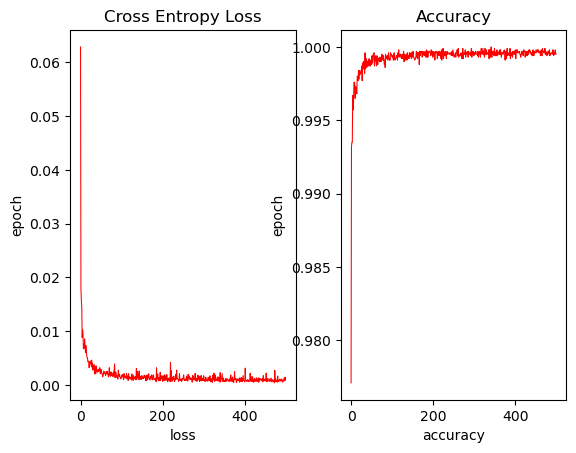

In [28]:
fig, ax = plt.subplots(1,2)
ax[0].plot(history_lobe.history['loss'], c='red', lw = 0.75)
ax[0].set_xlabel('loss')
ax[0].set_ylabel('epoch')
ax[0].set_title('Cross Entropy Loss')

ax[1].plot(history_lobe.history['accuracy'], c='red', lw = 0.75)
ax[1].set_xlabel('accuracy')
ax[1].set_ylabel('epoch')
ax[1].set_title('Accuracy')

Text(0.5, 1.0, 'Accuracy')

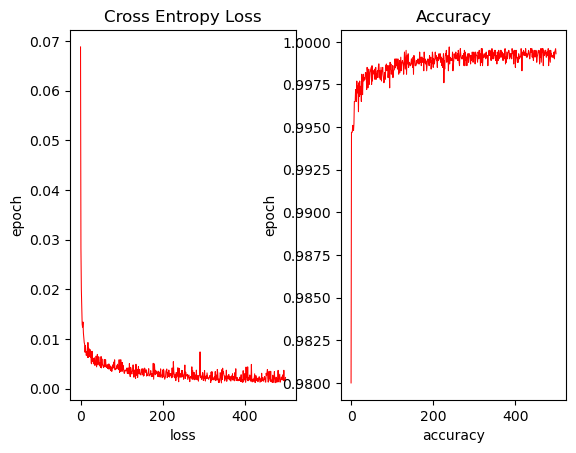

In [29]:
fig, ax = plt.subplots(1,2)
ax[0].plot(history_trans.history['loss'], c='red', lw = 0.75)
ax[0].set_xlabel('loss')
ax[0].set_ylabel('epoch')
ax[0].set_title('Cross Entropy Loss')

ax[1].plot(history_trans.history['accuracy'], c='red', lw = 0.75)
ax[1].set_xlabel('accuracy')
ax[1].set_ylabel('epoch')
ax[1].set_title('Accuracy')

In [30]:
yhat_state = lobe_state_model.predict(xlobe)
yhat_trans = lobe_trans_model.predict(xlobe)

313/313 [==============================] - 0s 532us/step


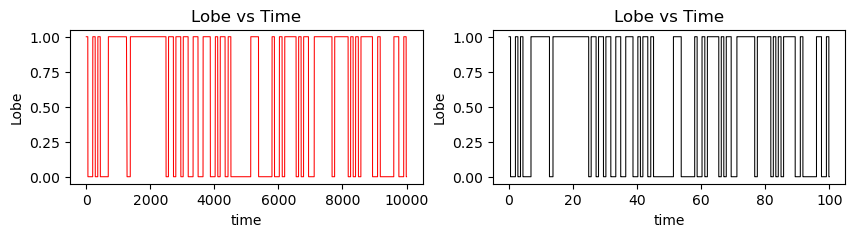

In [67]:
# Plotting Lorenz System
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(2)
ax[0].plot(yhat_state, c='red', lw = 0.75)
ax[0].set_xlabel('time')
ax[0].set_ylabel('Lobe')
ax[0].set_title('Lobe vs Time')

ax[1].step(t, ylobe, c='black', lw = 0.75)
ax[1].set_xlabel('time')
ax[1].set_ylabel('Lobe')
ax[1].set_title('Lobe vs Time')

plt.savefig('lorenz-lobes-pred', bbox_inches='tight',dpi = 200)


accuracy= [0.98020196]


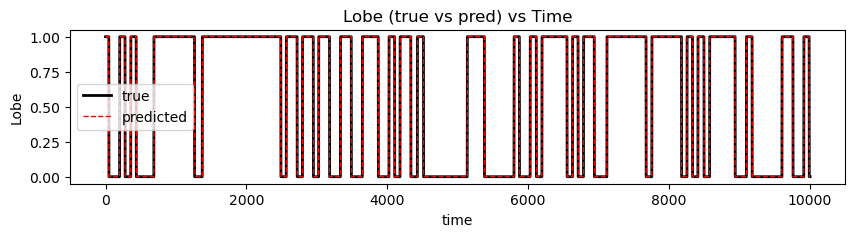

In [68]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2)
ax.plot(ylobe, c='black', lw = 2)
ax.plot(yhat_state, c='red', linestyle='--', lw = 1)
ax.set_xlabel('time')
ax.set_ylabel('Lobe')
ax.set_title('Lobe (true vs pred) vs Time')
ax.legend( ['true','predicted'])

plt.savefig('lorenz-lobes-pred-2', bbox_inches='tight',dpi = 200)

print('accuracy=',tf.metrics.binary_accuracy(yhat_state.T,ylobe).numpy())

accuracy= [0.9996]
number of transitions= 53.0
missing transitions= 4.0


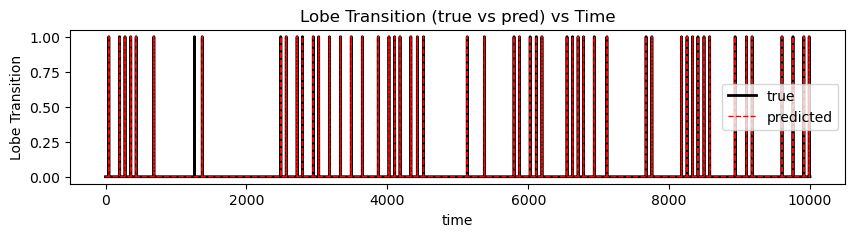

In [74]:
yhat_trans_p = yhat_trans[:10000].copy()
yhat_trans_p[yhat_trans_p>0.5]=1
yhat_trans_p[yhat_trans_p<0.5]=0

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2)
ax.plot(ytrans, c='black', lw = 2)
ax.plot(yhat_trans_p, c='red', linestyle='--', lw = 1)
ax.set_xlabel('time')
ax.set_ylabel('Lobe Transition')
ax.set_title('Lobe Transition (true vs pred) vs Time')
ax.legend( ['true','predicted'])

plt.savefig('lorenz-lobes-pred-2', bbox_inches='tight',dpi = 200)

print('accuracy=',tf.metrics.binary_accuracy(yhat_trans_p.T,ytrans).numpy())
print('number of transitions=', np.sum(ytrans))
print('missing transitions=', np.sum(np.abs(yhat_trans_p.T -  ytrans)))


313/313 [==============================] - 0s 558us/step
accuracy= [0.9997]
number of transitions= 53.0
missing transitions= 3.0


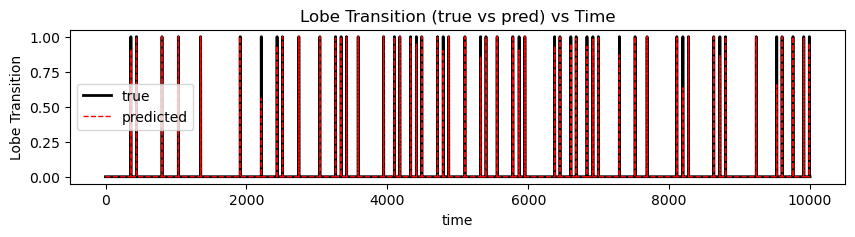

In [73]:
# Predicting on unseen data
x0test = [4,4,27]
t = np.linspace(0, 100, num_pts)
soltest = odeint(Lorenz, x0test, t, args=(rho_train[1],))
xtest = soltest[:,0]; ytest = soltest[:,1]; ztest = soltest[:,2]

xlobe_test = np.array([xtest,ytest,ztest]).T

x_negtest = np.argwhere(xtest<0)
ylobetest = np.ones(num_pts)
ylobetest[x_negtest] = 0
ytranstest = np.abs(ylobetest[1:num_pts] - ylobetest[0:(num_pts-1)])

yhat_trans_test = lobe_trans_model.predict(xlobe_test)

yhat_trans_test_p = yhat_trans_test[:10000].copy()
yhat_trans_test_p[yhat_trans_test_p>0.5]=1
yhat_trans_test_p[yhat_trans_test_p<0.5]=0

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2)
ax.plot(ytranstest, c='black', lw = 2)
ax.plot(yhat_trans_test[:10000], c='red', linestyle='--', lw = 1)
ax.set_xlabel('time')
ax.set_ylabel('Lobe Transition')
ax.set_title('Lobe Transition (true vs pred) vs Time')
ax.legend( ['true','predicted'])

plt.savefig('lorenz-lobes-pred-test', bbox_inches='tight',dpi = 200)

print('accuracy=',tf.metrics.binary_accuracy(yhat_trans_test_p.T,ytranstest).numpy())
print('number of transitions=', np.sum(ytranstest))
print('missing transitions=', np.sum(np.abs(yhat_trans_test_p.T -  ytranstest)))
